In [8]:
# !pip install dgl
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !sudo apt-get install -y fonts-nanum


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import os
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

plt.rc('font', family='NanumBarunGothic')

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='fiona._env')

F0 = '/content/gdrive/My Drive/seoulmovingdata/시도경계/LARD_ADM_SECT_SGG_11.shp'
map0 = gpd.read_file(F0, encoding='cp949')
map0 = map0.sort_values(by='SGG_NM')


# prepare and read data
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({ 'ADM_CD' : 'int' })
df1.info()
map = df1 # 서울시 한정 [df1['ADM_CD']<20000000]

os.environ['SHAPE_ENCODING'] = "UTF-8"
F2 = '/content/gdrive/My Drive/seoulmovingdata/상권지도/TBGIS_TRDAR_RELM.shp'
map2 = gpd.read_file(F2, encoding='UTF-8')

F3 = '/content/gdrive/My Drive/seoulmovingdata/시도경계/LARD_ADM_SECT_SGG_11.shp'
map3 = gpd.read_file(F3, encoding='cp949')
map3 = map3.sort_values(by='SGG_NM')
# map3['SGG_NM'].unique().tolist()
# sorted(map3['SGG_NM'].unique().tolist())

#기타 서울 관련

file_seuol_1 = '/content/gdrive/My Drive/seoulmovingdata/서울관련데이터/서울시 상권분석서비스(자치구별 상권변화지표) (1).csv'
graphic1 = pd.read_csv(file_seuol_1, encoding='cp949', index_col = None)
file_seuol_2 = '/content/gdrive/My Drive/seoulmovingdata/서울관련데이터/서울시 상권분석서비스(행정동별 상권변화지표).csv'
graphic2 = pd.read_csv(file_seuol_2, encoding='cp949', index_col = None)
# file_seuol_3 = '/content/gdrive/My Drive/seoulmovingdata/서울관련데이터/서울시 상권분석서비스(상권배후지-추정매출).csv'
# graphic3 = pd.read_csv(file_seuol_3, encoding='cp949', index_col = None)


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3518 entries, 0 to 3517
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BASE_DATE  3518 non-null   object  
 1   ADM_CD     3518 non-null   int64   
 2   ADM_NM     3518 non-null   object  
 3   geometry   3518 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 110.1+ KB


## 분석파트

In [11]:
file_path_0 = '/content/gdrive/My Drive/seoulmovingdata/서울생활이동데이터_행정동코드_20210907.xlsx'
try:
    df_0 = pd.read_excel(file_path_0)
except UnicodeDecodeError:
    df_0 = pd.read_excel(file_path_0)  # 또는 encoding='euc-kr'
except Exception as e0:
    print("Error:", e0)

print(df_0.head())
print(df_0['full_name'].unique() )
seoul_districts = sorted(df_0['name'].unique().tolist())

df_0.rename(columns={'시도': 'state', '시군구': 'city', '읍면동':'dong' , 'name': 'name', 'full_name': "full_name"}, inplace=True)
print(df_0['city'].unique() )
df_1 = df_0[df_0['state'] == 11000 ].sort_values(by='name') #서울특별시
df_2 = df_0[df_0['state'] == 23000 ].sort_values(by='name') #인청광역시
df_3 = df_0[df_0['state'] == 31000 ].sort_values(by='name') #경기도
df_all = df_0[ (df_0['state'] == 11000 ) | (df_0['state'] == 23000 ) | (df_0['state'] == 31000 )].sort_values(by='name')
# print("전체")
# print(df_0['name'].unique() )
# print("서울")
# print(df_1['name'].unique() )
# print("인천")
# print(df_2['name'].unique() )
# print("경기")
# print(df_3['name'].unique() )
result_df = df_0[df_0['name'].isin(seoul_districts)]
# result_df = result_df.drop(result_df.index[-1])
result_df = result_df.sort_values(by='name')
# 서울시 안에 해당하는 것만 추출하기.
print(result_df['name'].unique())
# print(result_df.sort_values(by='name'))
seoul_districts_english = ['Gangnam-gu', 'Gangdong-gu', 'Gangbuk-gu', 'Gangseo-gu', 'Gwanak-gu', 'Gwangjin-gu',
                'Guro-gu', 'Geumcheon-gu', 'Nowon-gu', 'Dobong-gu', 'Dongdaemun-gu', 'Dongjak-gu',
                'Mapo-gu', 'Seodaemun-gu', 'Seocho-gu', 'Seongdong-gu', 'Seongbuk-gu', 'Songpa-gu',
                'Yangcheon-gu', 'Yeongdeungpo-gu', 'Yongsan-gu', 'Eunpyeong-gu', 'Jongno-gu', 'Jung-gu', 'Jungnang-gu']

# dong_name = sorted(result_df['name'].unique().tolist())
dong_name_two = ['군자동','화양동']
print(len(df_1), len(df_2), len(df_3), len(df_all))
print(result_df.head())

      시도    시군구      읍면동 name      full_name
0  11000  11010  1101053  사직동  서울특별시 종로구 사직동
1  11000  11010  1101054  삼청동  서울특별시 종로구 삼청동
2  11000  11010  1101055  부암동  서울특별시 종로구 부암동
3  11000  11010  1101056  평창동  서울특별시 종로구 평창동
4  11000  11010  1101057  무악동  서울특별시 종로구 무악동
['서울특별시 종로구 사직동' '서울특별시 종로구 삼청동' '서울특별시 종로구 부암동' ... '경상북도' '경상남도'
 '제주특별자치도']
[11010 11020 11030 11040 11050 11060 11070 11080 11090 11100 11110 11120
 11130 11140 11150 11160 11170 11180 11190 11200 11210 11220 11230 11240
 11250 21000 22000 23010 23020 23030 23040 23050 23060 23070 23080 23310
 23320 24000 25000 26000 29000 31011 31012 31013 31014 31021 31022 31023
 31030 31041 31042 31050 31060 31070 31080 31091 31092 31101 31103 31104
 31110 31120 31130 31140 31150 31160 31170 31180 31191 31192 31193 31200
 31210 31220 31230 31240 31250 31260 31270 31280 31350 31370 31380 32000
 33000 34000 35000 36000 37000 38000 39000]
['가남읍' '가능1동' '가락1동' ... '흥도동' '흥선동' '흥천면']
424 151 563 1138
      state   city     dong  name  

In [12]:
# folder_path = '/content/gdrive/My Drive/seoulmovingdata/2023/LOCAL_PEOPLE_DONG_202301.csv'
# test = pd.read_csv(folder_path, encoding='utf-8', index_col = None)
# test.head()
# columns_name = test.columns.tolist()
# test_reset = test.reset_index()
# test_reset = test_reset.drop(columns=test_reset.columns[-1])
# test_reset.columns = columns_name
# test_reset.head()
# print(columns_name)
# test_reset['시간대구분'].unique()


In [13]:
print(result_df[result_df['name'] == '군자동'])
print(result_df[result_df['name'] == '화양동'])

     state   city     dong name      full_name
66   11000  11050  1105054  군자동  서울특별시 광진구 군자동
916  31000  31150  3115068  군자동    경기도 시흥시 군자동
    state   city     dong name      full_name
65  11000  11050  1105053  화양동  서울특별시 광진구 화양동


In [14]:
#시간대별로 i-->j로 가는 전체 데이터를 생성하기.
#population_moving_amount 하나는 시간대별 하나
#그 리스트 안에 [i]는 i에서 출발하고 [i][j]에 해당하는 값! 이 i-->j로 가는 인구이동량
#순서는 seoul_districts에 저장되어 있음.
plt.figure(figsize=[10, 10])
image_paths = []
# 파일이 있는 폴더 경로 설정
folder_path = '/content/gdrive/My Drive/seoulmovingdata/202303'

dong_name_seoul = df_1['dong'].unique() ; #print(dong_name_seoul)
dong_name_inc = df_2['dong'].unique() ; #print(dong_name_inc)
dong_name_gye = df_3['dong'].unique() ; #print(dong_name_gye)

dong_name_two = [ 1105054 ] #,1105054 1105053 ]  #['군자동','화양동']

dong_name = df_all['dong'].unique()
dong_name = dong_name[~np.isin(dong_name, dong_name_two)]
dong_name_real = df_all['name'].unique()
dong_name_real = dong_name_real[~np.isin(dong_name_real, dong_name_two)]
print(len(dong_name), len(dong_name_real) )
print(dong_name)

time_bin = []
time_bin2 = []

# 폴더 안에 있는 파일 목록 불러오기
file_list = os.listdir(folder_path)
file_list = sorted(file_list)
print("파일 목록", file_list)

combined_list = []
for file_name in file_list[7:11]:
    df_name = file_name.split('.')[0] + file_name.split('.')[1]  # 파일 이름에서 확장자를 제외한 이름을 데이터프레임의 이름으로 사용
    print("파일이름:", df_name)
    if file_name.endswith('.csv') :  # 확장자가 .csv인 파일들만 처리
      file_path = os.path.join(folder_path, file_name) ; print(file_name)
      try:
          df = pd.read_csv(file_path, encoding='utf-8')
      except UnicodeDecodeError:
          df = pd.read_csv(file_path, encoding='cp949')  # 또는 encoding='euc-kr'
      except Exception as e:
          print("Error:", e)
      # 열 이름 변경
      df.rename(columns={'대상연월': 'date', '요일': 'day', '도착시간': 'time(hour)', '출발 행정동 코드': 'star_area', '도착 행정동 코드': 'dest_area', '성별' : 'sex', '나이':'age', '이동유형':'moving_type', '평균 이동 시간(분)':'mean moving time', '이동인구(합)':'person'}, inplace=True)
      #데이터 안에 *이 있어서 0으로 표시 후 실수값으로 전처리
      print(df.columns)
      df['mean moving time'] = df['mean moving time'].replace('*', '0')
      df['mean moving time'] = df['mean moving time'].astype(float)

      #인구 이동량 데이터 생성.
      population_moving_amount = []
      for star_distr in dong_name:
        pocket = []
        #출발역의 코드번호 추출.
        # print(star_distr)
        # star_code = pd.to_numeric(df_all[df_all['dong'] == star_distr ]).values
        # print(star_code)
        # if len(star_code) >= 2: print("1. 에러 의심!!!!!!!!", star_code)
        # #지정한 출발역을 값는 행만 추출. (데이터 프레임.)

        a2 = df[ df['star_area'] == star_distr ]


        for dest_code in dong_name_two:
          #출발역으로 한번거른 a2 데이터 프레임 안에서 지정한 도착역으로 가는 행만따로 추출.
          a3 = a2[ (a2['dest_area'] == dest_code) & ( (a2['age'] == 20 ) ) & ( (a2['day'] == '월') | (a2['day'] == '화') | (a2['day'] == '수') | (a2['day'] == '목') | (a2['day'] == '금') )]
          # print("출발구", star_distr, star_code ,"도착구", dest_distr, dest_code, "총이동인원", int(a3['person'].sum()))
          for index, row in a3.iterrows():
              # 2. 원하는 값을 리스트에 추가
              if row['person'] != '*':
                time_bin.append([row['mean moving time'], row['person'], row['star_area']])
                # time_bin2.append([row['mean moving time'], row['person'], row['star_area']])
      #   mean_value = a3['mean moving time'].mean()
      #   if not pd.isna(mean_value):  # 평균값이 NaN이 아닐 경우
      #       pocket.append(int(mean_value))
      #   else: pocket.append(int(0))
      #   population_moving_amount.append(pocket)
      # if len(combined_list) == 0: combined_list = population_moving_amount
      # else: combined_list = [[a + b for a, b in zip(row1, row2)] for row1, row2 in zip(combined_list, population_moving_amount)]
      # print("정제된 인구이동데이터", population_moving_amount)
      # print("합쳐진 데이터",len(combined_list), combined_list)

timebin_df = pd.DataFrame(time_bin, columns=['mean moving time', 'person', 'star_area'])
timebin_df_ori = timebin_df.copy()
timebin_df.head()

1137 1103
[3128011 3103061 1124066 ... 3110153 3103067 3128033]
파일 목록 ['생활이동_행정동_2023.03_00시.csv', '생활이동_행정동_2023.03_01시.csv', '생활이동_행정동_2023.03_02시.csv', '생활이동_행정동_2023.03_03시.csv', '생활이동_행정동_2023.03_04시.csv', '생활이동_행정동_2023.03_05시.csv', '생활이동_행정동_2023.03_06시.csv', '생활이동_행정동_2023.03_07시.csv', '생활이동_행정동_2023.03_08시.csv', '생활이동_행정동_2023.03_09시.csv', '생활이동_행정동_2023.03_10시.csv', '생활이동_행정동_2023.03_11시.csv', '생활이동_행정동_2023.03_12시.csv', '생활이동_행정동_2023.03_13시.csv', '생활이동_행정동_2023.03_14시.csv', '생활이동_행정동_2023.03_15시.csv', '생활이동_행정동_2023.03_16시.csv', '생활이동_행정동_2023.03_17시.csv', '생활이동_행정동_2023.03_18시.csv', '생활이동_행정동_2023.03_19시.csv', '생활이동_행정동_2023.03_20시.csv', '생활이동_행정동_2023.03_21시.csv', '생ᄒ

,mean moving time,person,star_area
0,42.0,6.57,1123080
1,82.0,6.63,3125053
2,55.0,4.36,1117054
3,55.0,4.36,1117054
4,52.0,4.40,3119256


<Figure size 1000x1000 with 0 Axes>

In [15]:
df.head()

,date,day,time(hour),star_area,dest_area,sex,age,moving_type,mean moving time,person
0,202303,일,10,1101053,1101053,M,30,EH,12.0,*
1,202303,일,10,1101053,1101053,F,0,EE,1.0,27.99
2,202303,일,10,1101053,1101053,F,10,EE,5.0,6.04
3,202303,일,10,1101053,1101053,F,10,HE,135.0,5.95
4,202303,일,10,1101053,1101053,F,10,HW,27.0,5.94


## 속도 분포

In [16]:
timebin_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4485 entries, 0 to 4484
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mean moving time  4485 non-null   float64
 1   person            4485 non-null   object 
 2   star_area         4485 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 105.2+ KB


In [17]:
timebin_df['person'] = timebin_df['person'].replace('*', '0').astype(float)
timebin_df['mean moving time'] = timebin_df['mean moving time'].round().astype(int)
timebin_df['person'] = timebin_df['person'].round().astype(int)
timebin_df.dtypes

mean moving time    int64
person              int64
star_area           int64
dtype: object

In [18]:

timebin_df

,mean moving time,person,star_area
0,42,7,1123080
1,82,7,3125053
2,55,4,1117054
3,55,4,1117054
4,52,4,3119256
...,...,...,...
4480,93,9,3110153
4481,93,5,3103067
4482,84,8,3103067
4483,101,4,3103067


In [19]:
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({ 'ADM_CD' : 'int' })
df1.info()
map = df1 # 서울시 한정 [df1['ADM_CD']<20000000]
map = map.sort_values(by='ADM_NM')
map_ori = map.copy(deep=True)
map['ADM_CD'] = map['ADM_CD'] // 10
# 각 행정동의 중심점 계산
map['centroid'] = map['geometry'].centroid

# x_centroid와 y_centroid 열 추가
map['x_centroid'] = map['centroid'].x
map['y_centroid'] = map['centroid'].y
map.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3518 entries, 0 to 3517
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BASE_DATE  3518 non-null   object  
 1   ADM_CD     3518 non-null   int64   
 2   ADM_NM     3518 non-null   object  
 3   geometry   3518 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 110.1+ KB


,BASE_DATE,ADM_CD,ADM_NM,geometry,centroid,x_centroid,y_centroid
2005,20220630,3304354,가경동,"POLYGON ((238950.246 348040.672, 238960.635 34...",POINT (238772.682 346655.364),238772.682280,346655.364351
3257,20220630,3808055,가곡동,"POLYGON ((362995.030 221745.449, 363023.674 22...",POINT (361602.996 220898.465),361602.995578,220898.464927
2080,20220630,3358033,가곡면,"POLYGON ((329921.049 397614.347, 329944.352 39...",POINT (327324.325 391286.460),327324.325034,391286.459680
1843,20220630,3207035,가곡면,"POLYGON ((393701.795 413370.265, 393711.539 41...",POINT (392658.976 404669.599),392658.976209,404669.599373
1700,20220630,3128011,가남읍,"POLYGON ((248869.160 418216.445, 248845.338 41...",POINT (251431.298 412079.760),251431.298370,412079.759792


In [20]:
merged_df = timebin_df.merge(map, left_on='star_area', right_on='ADM_CD', how='left')
merged_df = merged_df.dropna()
missing_values = merged_df.isnull().sum()
print(missing_values)
merged_df.head()

mean moving time    0
person              0
star_area           0
BASE_DATE           0
ADM_CD              0
ADM_NM              0
geometry            0
centroid            0
x_centroid          0
y_centroid          0
dtype: int64


,mean moving time,person,star_area,BASE_DATE,ADM_CD,ADM_NM,geometry,centroid,x_centroid,y_centroid
0,42,7,1123080,20220630,1123080.0,개포2동,"POLYGON ((206365.373 443303.123, 206376.863 44...",POINT (206033.835 442499.989),206033.835285,442499.988779
2,55,4,1117054,20220630,1117054.0,구로3동,"POLYGON ((190681.374 443313.413, 190688.025 44...",POINT (190636.023 442525.358),190636.022643,442525.358124
3,55,4,1117054,20220630,1117054.0,구로3동,"POLYGON ((190681.374 443313.413, 190688.025 44...",POINT (190636.023 442525.358),190636.022643,442525.358124
4,52,4,3119256,20220630,3119256.0,구성동,"POLYGON ((213319.907 422681.169, 213327.983 42...",POINT (212456.721 421498.500),212456.721112,421498.500317
5,9,6,1105061,20220630,1105061.0,구의2동,"POLYGON ((209201.107 450461.742, 209200.130 45...",POINT (208312.440 449874.914),208312.439774,449874.913801


In [21]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # 지구의 반경 (킬로미터)

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)

    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# 군자동의 centroid 값
print(map[map['ADM_CD']== 1105054 ])
gunja_row = map[map['ADM_CD']== 1105054 ].iloc[0]
gunja_lat = gunja_row['y_centroid']
gunja_lon = gunja_row['x_centroid']

# 각 행정동의 centroid와 군자동과의 거리 계산
merged_df['distance_from_gunja'] = merged_df.apply(lambda row: haversine_distance(gunja_lat, gunja_lon, row['y_centroid'], row['x_centroid']), axis=1)

#단위 스케일링
# 속력계산
merged_df['velocity(m/s)'] = merged_df['distance_from_gunja'] / merged_df['mean moving time']

merged_df = merged_df[merged_df['velocity(m/s)'] != 0]
merged_df = merged_df[np.isfinite(merged_df['velocity(m/s)'])]
merged_df['velocity(m/s)'] = merged_df['velocity(m/s)'].astype(int)
merged_df['velocity(m/s)'] = merged_df['velocity(m/s)'] * 60
merged_df['velocity(m/s)'] = merged_df['velocity(m/s)'].astype(int)
merged_df['velocity(km/h)'] = merged_df['velocity(m/s)'] * 3.6

# grouped['ADM_CD'] = grouped['ADM_CD'].astype(int)
merged_df

   BASE_DATE   ADM_CD ADM_NM  \
66  20220630  1105054    군자동   

                                             geometry  \
66  POLYGON ((206931.899 450497.584, 206920.146 45...   

                         centroid     x_centroid     y_centroid  
66  POINT (206443.412 450088.451)  206443.412456  450088.451194  


,mean moving time,person,star_area,BASE_DATE,ADM_CD,ADM_NM,geometry,centroid,x_centroid,y_centroid,distance_from_gunja,velocity(m/s),velocity(km/h)
0,42,7,1123080,20220630,1123080.0,개포2동,"POLYGON ((206365.373 443303.123, 206376.863 44...",POINT (206033.835 442499.989),206033.835285,442499.988779,3227.840543,4560,16416.0
2,55,4,1117054,20220630,1117054.0,구로3동,"POLYGON ((190681.374 443313.413, 190688.025 44...",POINT (190636.023 442525.358),190636.022643,442525.358124,382.489018,360,1296.0
3,55,4,1117054,20220630,1117054.0,구로3동,"POLYGON ((190681.374 443313.413, 190688.025 44...",POINT (190636.023 442525.358),190636.022643,442525.358124,382.489018,360,1296.0
4,52,4,3119256,20220630,3119256.0,구성동,"POLYGON ((213319.907 422681.169, 213327.983 42...",POINT (212456.721 421498.500),212456.721112,421498.500317,16891.466690,19440,69984.0
5,9,6,1105061,20220630,1105061.0,구의2동,"POLYGON ((209201.107 450461.742, 209200.130 45...",POINT (208312.440 449874.914),208312.439774,449874.913801,16172.385590,107760,387936.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4495,19,6,1106073,20220630,1106073.0,휘경2동,"POLYGON ((206256.181 453967.683, 206269.675 45...",POINT (205744.071 453817.044),205744.071491,453817.043763,14287.541541,45060,162216.0
4500,93,5,3103067,20220630,3103067.0,흥선동,"POLYGON ((201310.924 472465.478, 201318.596 47...",POINT (201536.303 470708.938),201536.303372,470708.937761,10883.975417,7020,25272.0
4501,84,8,3103067,20220630,3103067.0,흥선동,"POLYGON ((201310.924 472465.478, 201318.596 47...",POINT (201536.303 470708.938),201536.303372,470708.937761,10883.975417,7740,27864.0
4502,101,4,3103067,20220630,3103067.0,흥선동,"POLYGON ((201310.924 472465.478, 201318.596 47...",POINT (201536.303 470708.938),201536.303372,470708.937761,10883.975417,6420,23112.0


In [22]:
merged_df[merged_df['ADM_NM'] == '내손1동']

,mean moving time,person,star_area,BASE_DATE,ADM_CD,ADM_NM,geometry,centroid,x_centroid,y_centroid,distance_from_gunja,velocity(m/s),velocity(km/h)
259,82,11,3117054,20220630,3117054.0,내손1동,"POLYGON ((197754.760 431645.268, 197766.183 43...",POINT (197903.869 430529.554),197903.86897,430529.55444,13422.860706,9780,35208.0
260,72,11,3117054,20220630,3117054.0,내손1동,"POLYGON ((197754.760 431645.268, 197766.183 43...",POINT (197903.869 430529.554),197903.86897,430529.55444,13422.860706,11160,40176.0
1556,70,5,3117054,20220630,3117054.0,내손1동,"POLYGON ((197754.760 431645.268, 197766.183 43...",POINT (197903.869 430529.554),197903.86897,430529.55444,13422.860706,11460,41256.0
1557,89,14,3117054,20220630,3117054.0,내손1동,"POLYGON ((197754.760 431645.268, 197766.183 43...",POINT (197903.869 430529.554),197903.86897,430529.55444,13422.860706,9000,32400.0
2826,114,16,3117054,20220630,3117054.0,내손1동,"POLYGON ((197754.760 431645.268, 197766.183 43...",POINT (197903.869 430529.554),197903.86897,430529.55444,13422.860706,7020,25272.0
2827,97,8,3117054,20220630,3117054.0,내손1동,"POLYGON ((197754.760 431645.268, 197766.183 43...",POINT (197903.869 430529.554),197903.86897,430529.55444,13422.860706,8280,29808.0
2828,125,11,3117054,20220630,3117054.0,내손1동,"POLYGON ((197754.760 431645.268, 197766.183 43...",POINT (197903.869 430529.554),197903.86897,430529.55444,13422.860706,6420,23112.0


In [23]:
Q1 = merged_df['velocity(m/s)'].quantile(0.25)
Q3 = merged_df['velocity(m/s)'].quantile(0.75)
IQR = Q3 - Q1

# IQR을 사용하여 이상치를 필터링
filtered_df = merged_df[~((merged_df['velocity(m/s)'] < (Q1 - 1.5 * IQR)) |
                          (merged_df['velocity(m/s)'] > (Q3 + 1.5 * IQR)))].copy()


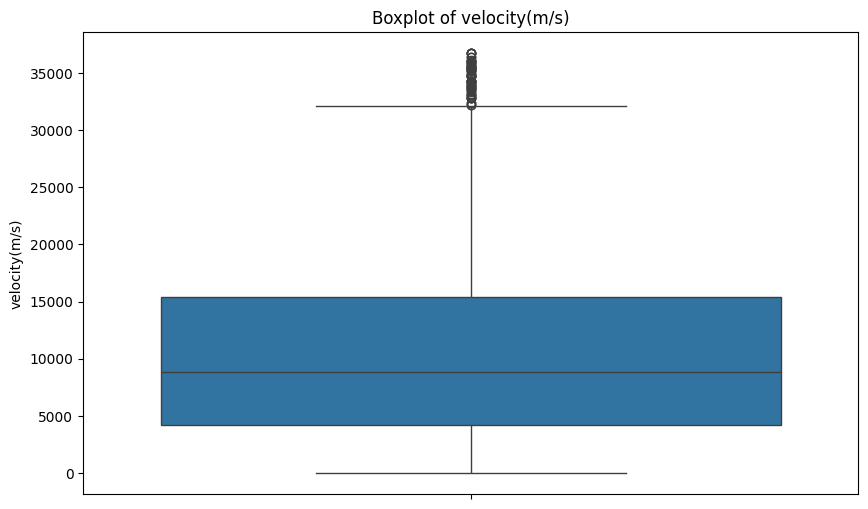

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(filtered_df['velocity(m/s)'])
plt.title('Boxplot of velocity(m/s)')
plt.show()

   velocity(m/s)  person
0              0       8
1             60      29
2            120      87
3            180      68
4            240      51
Weighted Average: 8716.46
Mode: 480
Skewness: 1.02
Kurtosis: 0.43


<Figure size 1000x800 with 0 Axes>

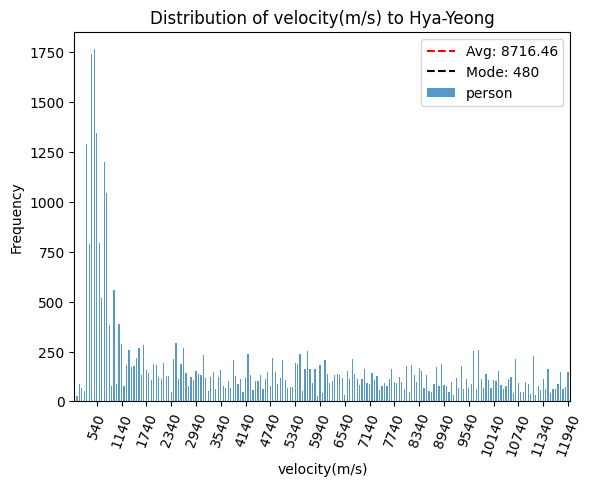

In [25]:


# 'mean moving time'을 기준으로 그룹화하고 'person' 값 합계
timebin_cal_df = filtered_df.groupby('velocity(m/s)').agg({'person': 'sum'}).reset_index()
print(timebin_cal_df.head())

import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# 가중치를 고려하여 왜도와 첨도 계산
data_expanded = []  # 데이터 확장
for index, row in timebin_cal_df.iterrows():
    data_expanded.extend([row['velocity(m/s)']] * row['person'])
skewness = skew(data_expanded)
kurt = kurtosis(data_expanded)

#  평균
weighted_avg = (timebin_cal_df['velocity(m/s)'] * timebin_cal_df['person']).sum() / timebin_cal_df['person'].sum()

# 최빈값
mode_value = timebin_cal_df.loc[timebin_cal_df['person'].idxmax(), 'velocity(m/s)']

# 통계량 출력
print(f"Weighted Average: {weighted_avg:.2f}")
print(f"Mode: {mode_value}")
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurt:.2f}")

# Plot 그리기
plt.figure(figsize=(10,8))
timebin_cal_df.plot(x='velocity(m/s)', y='person', kind='bar', legend=None, alpha=0.75)
plt.axvline(x=weighted_avg, color='r', linestyle='--', label=f"Avg: {weighted_avg:.2f}")
plt.axvline(x=mode_value, color='k', linestyle='--', label=f"Mode: {mode_value}")
# plt.axvline(x=90, color='b', linestyle='--')
plt.xlabel('velocity(m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of velocity(m/s) to Hya-Yeong')
# X축 틱 설정
max_val = 200
min_val = 0
plt.xticks(np.arange(-1, 201,10 ), rotation=70)
plt.xlim([min_val, max_val])
plt.legend()
plt.show()

In [26]:
average_velocity = merged_df.groupby('ADM_CD')['velocity(m/s)'].mean().reset_index()
average_velocity.rename(columns={'velocity(m/s)': 'avg_velocity(m/s)'}, inplace=True)


## 시간 분포

In [27]:
# 평균을 위한 계산
timebin_df['weighted_time'] = timebin_df['mean moving time'] * timebin_df['person']
grouped = timebin_df.groupby('star_area').agg({
    'weighted_time': 'sum',
    'person': 'sum'
}).reset_index()

grouped['weighted_avg'] = (grouped['weighted_time'] / grouped['person'] * 60).round().astype(int)
# 결과 출력
print(grouped[['star_area', 'weighted_avg', 'person']])

     star_area  weighted_avg  person
0      1101055          4378      38
1      1101056          3960       7
2      1101061          2875      36
3      1101064          3000       4
4      1101067          4680       6
..         ...           ...     ...
618    3137032          6125      26
619    3138011          4560       5
620    3138035          5522      29
621    3138040          7280      33
622    3138041          7193      26

[623 rows x 3 columns]


분포그래프

   mean moving time  person
0                 1      12
1                 2      12
2                 3      24
3                 4      77
4                 5      78
Weighted Average: 66.05
Mode: 48
Skewness: 1.68
Kurtosis: 12.59


<Figure size 1000x800 with 0 Axes>

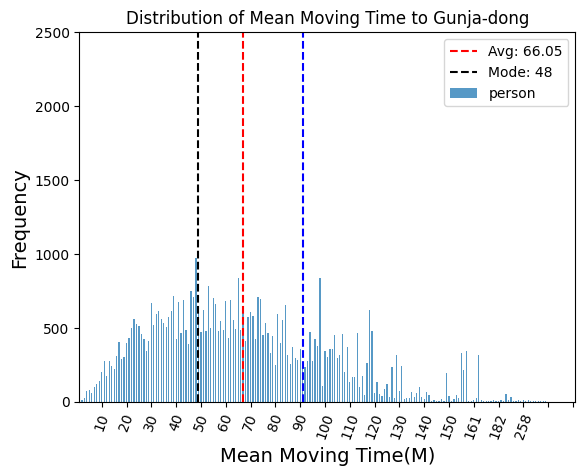

90 value is at 75.01% of the cumulative distribution.


In [28]:


# 'mean moving time'을 기준으로 그룹화하고 'person' 값 합계
timebin_cal_df = timebin_df.groupby('mean moving time').agg({'person': 'sum'}).reset_index()
print(timebin_cal_df.head())

import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# 가중치를 고려하여 왜도와 첨도 계산
data_expanded = []  # 데이터 확장
for index, row in timebin_cal_df.iterrows():
    data_expanded.extend([row['mean moving time']] * row['person'])
skewness = skew(data_expanded)
kurt = kurtosis(data_expanded)

#  평균
weighted_avg = (timebin_cal_df['mean moving time'] * timebin_cal_df['person']).sum() / timebin_cal_df['person'].sum()
filtered_df = timebin_cal_df[timebin_cal_df['mean moving time'] <= 180]
weighted_avg_filtered = (filtered_df['mean moving time'] * filtered_df['person']).sum() / filtered_df['person'].sum()

# 최빈값
mode_value = timebin_cal_df.loc[timebin_cal_df['person'].idxmax(), 'mean moving time']

# 통계량 출력
print(f"Weighted Average: {weighted_avg_filtered:.2f}")
print(f"Mode: {mode_value}")
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurt:.2f}")

# Plot 그리기
plt.figure(figsize=(10,8))
timebin_cal_df.plot(x='mean moving time', y='person', kind='bar', legend=None, alpha=0.75)
plt.axvline(x=weighted_avg_filtered, color='r', linestyle='--', label=f"Avg: {weighted_avg_filtered:.2f}")
plt.axvline(x=mode_value, color='k', linestyle='--', label=f"Mode: {mode_value}")
plt.axvline(x=90, color='b', linestyle='--')
plt.xlabel('Mean Moving Time(M)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Mean Moving Time to Gunja-dong')
# X축 틱 설정
max_val = 200
min_val = 0
plt.xticks(np.arange(-1, 201,10 ), rotation=70)
plt.ylim([0, 2500])
plt.xlim([min_val, max_val])
plt.legend()
plt.show()

# 데이터 정렬
sorted_data = sorted(data_expanded)

# 90 값의 위치 찾기
index_90 = sorted_data.index(90)

# 누적분포 백분율 계산
cdf_90 = (index_90 + 1) / len(sorted_data) * 100

print(f"90 value is at {cdf_90:.2f}% of the cumulative distribution.")

Total sum of 'person': 54330


<Axes: ylabel='person'>

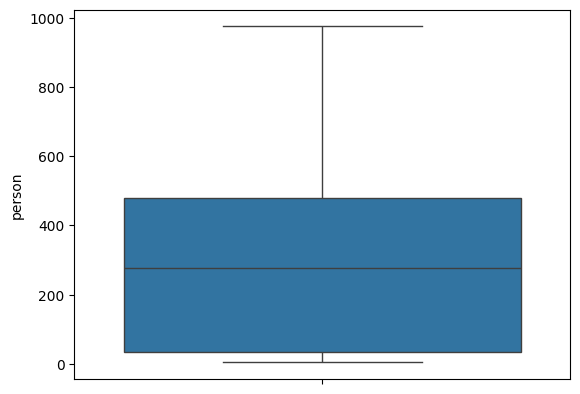

In [29]:
total_person = timebin_cal_df['person'].sum()
print("Total sum of 'person':", total_person)
sns.boxplot(timebin_cal_df['person'])
# timebin_cal_df

In [30]:
import numpy as np
import pandas as pd
from scipy.stats import norm, expon, lognorm, gamma, beta, chi2
from scipy.optimize import curve_fit

# 빈도를 고려한 데이터 확장
data_expanded = []
for index, row in timebin_cal_df.iterrows():
    data_expanded.extend([row['mean moving time']] * row['person'])

# 여러 분포에 대한 fit
distributions = [norm, expon, lognorm, gamma, beta, chi2]
results = {}
for dist in distributions:
    params = dist.fit(data_expanded)
    loglik = np.sum(dist.logpdf(data_expanded, *params))
    aic = 2*len(params) - 2*loglik
    results[dist.name] = aic

# AIC를 기반으로 최적의 분포 선택
best_fit = min(results, key=results.get)
print(f"Best fitting distribution: {best_fit} with AIC = {results[best_fit]}")

/usr/local/lib/python3.10/dist-packages/scipy/stats/_continuous_distns.py:719: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Best fitting distribution: beta with AIC = 536983.823500532


lognorm parameters:
Shape (s): 0.3608953838908243
Location (loc): -33.630145308219156
Scale: 94.19391342002075


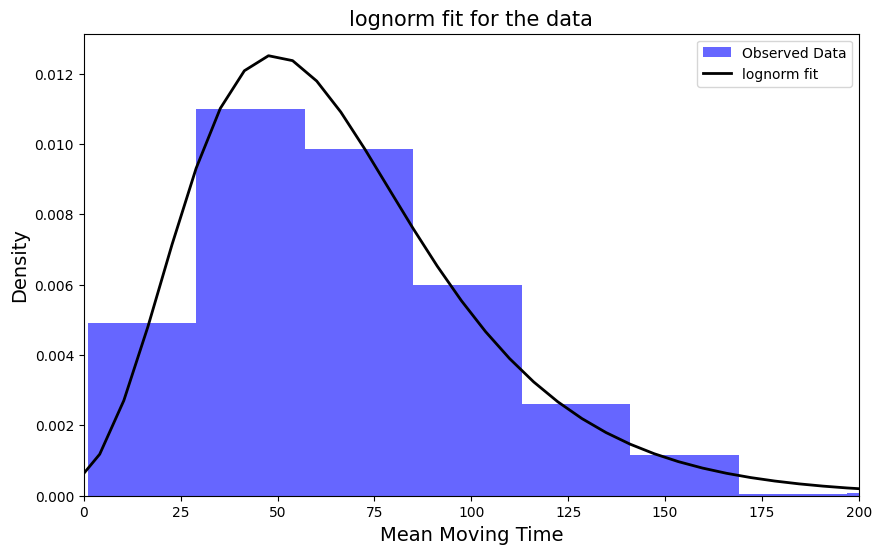

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# lognorm 분포의 모수 얻기
params_lognorm = lognorm.fit(data_expanded)
print(f"lognorm parameters:\nShape (s): {params_lognorm[0]}\nLocation (loc): {params_lognorm[1]}\nScale: {params_lognorm[2]}")

# 데이터와 lognorm 분포 함께 시각화하기
plt.figure(figsize=(10,6))
plt.hist(data_expanded, bins=20, density=True, alpha=0.6, color='b', label='Observed Data')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf_values_lognorm = lognorm.pdf(x, *params_lognorm)
plt.plot(x, pdf_values_lognorm, 'k', linewidth=2, label="lognorm fit")
plt.legend()
plt.xlim([min_val, max_val])
plt.title("lognorm fit for the data", fontsize=15)
plt.xlabel("Mean Moving Time", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()


lognorm parameters:
Shape (s): 0.3608953838908243
Location (loc): -33.630145308219156
Scale: 94.19391342002075
mu (mean of log-transformed data): 4.030774891621497
sigma^2 (variance of log-transformed data): 0.4024239079416941


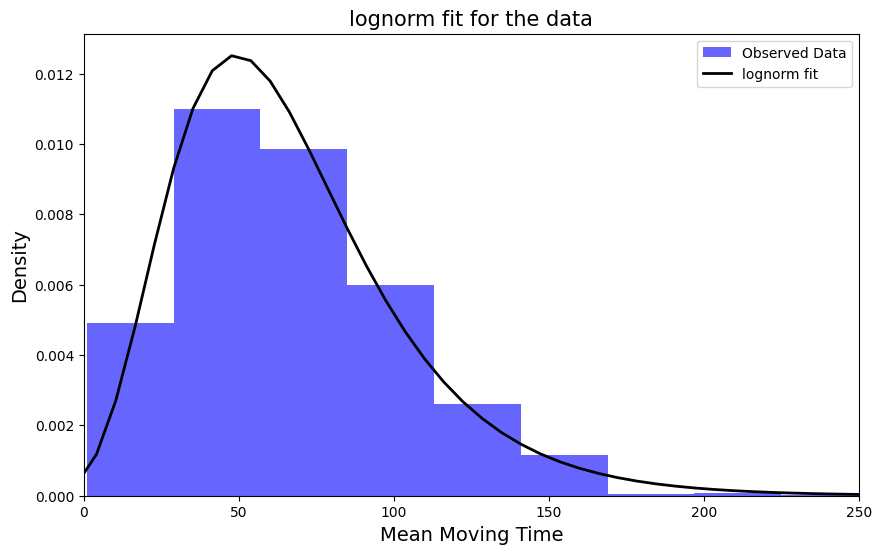

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import lognorm

# lognorm 분포의 모수 얻기
params_lognorm = lognorm.fit(data_expanded)
print(f"lognorm parameters:\nShape (s): {params_lognorm[0]}\nLocation (loc): {params_lognorm[1]}\nScale: {params_lognorm[2]}")

# 로그 변환된 데이터의 평균 및 분산 계산
log_data = np.log(data_expanded)
mu = np.mean(log_data)
sigma2 = np.var(log_data)
print(f"mu (mean of log-transformed data): {mu}")
print(f"sigma^2 (variance of log-transformed data): {sigma2}")

# 데이터와 lognorm 분포 함께 시각화하기
plt.figure(figsize=(10,6))
plt.hist(data_expanded, bins=20, density=True, alpha=0.6, color='b', label='Observed Data')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf_values_lognorm = lognorm.pdf(x, *params_lognorm)
plt.plot(x, pdf_values_lognorm, 'k', linewidth=2, label="lognorm fit")
plt.legend()
plt.xlim([min_val, 250])
plt.title("lognorm fit for the data", fontsize=15)
plt.xlabel("Mean Moving Time", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()


In [33]:
hwang = timebin_cal_df.copy(deep=True)
hwang

,mean moving time,person
0,1,12
1,2,12
2,3,24
3,4,77
4,5,78
...,...,...
184,351,6
185,527,6
186,530,6
187,560,6


In [37]:
gunja = timebin_cal_df.copy(deep=True)
gunja

,mean moving time,person
0,1,12
1,2,12
2,3,24
3,4,77
4,5,78
...,...,...
184,351,6
185,527,6
186,530,6
187,560,6


In [38]:
import numpy as np
from scipy.stats import ttest_ind

# 로그 변환
gunja['log_mean_moving_time'] = np.log(gunja['mean moving time'])
hwang['log_mean_moving_time'] = np.log(hwang['mean moving time'])

# t-test 수행
t_stat, p_value = ttest_ind(gunja['log_mean_moving_time'], hwang['log_mean_moving_time'])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

# 결과 확인
if p_value < 0.05:
    print("The two samples have statistically significant differences.")
else:
    print("The two samples do not have statistically significant differences.")


T-statistic: 0.0
P-value: 1.0
The two samples do not have statistically significant differences.


In [39]:
import numpy as np
from scipy.stats import t

# 데이터 샘플
data1_log = np.log(gunja["mean moving time"])
data2_log = np.log(hwang["mean moving time"])

# 표본 평균과 표준편차 계산
mean1, mean2 = np.mean(data1_log), np.mean(data2_log)
std1, std2 = np.std(data1_log, ddof=1), np.std(data2_log, ddof=1)
n1, n2 = len(data1_log), len(data2_log)

# 표본평균 차이
mean_diff = mean1 - mean2

# 표준오차 계산
se = np.sqrt((std1**2 / n1) + (std2**2 / n2))

# 자유도 계산
df = min(n1, n2) - 1

# 임계 t-값 계산 (95% 신뢰수준에서의 양쪽 꼬리)
tcrit = t.ppf(1 - 0.025, df)

# 신뢰구간 계산
lower_bound = mean_diff - (tcrit * se)
upper_bound = mean_diff + (tcrit * se)

print(f"95% confidence interval: ({lower_bound:.3f}, {upper_bound:.3f})")


95% confidence interval: (-0.206, 0.206)


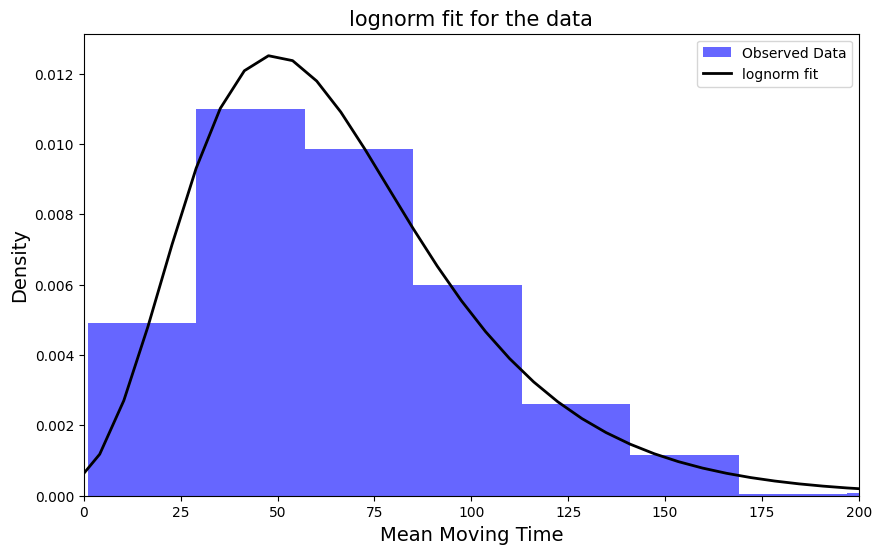

In [40]:
# 데이터와 lognorm 분포 함께 시각화하기
plt.figure(figsize=(10,6))
plt.hist(data_expanded, bins=20, density=True, alpha=0.6, color='b', label='Observed Data')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf_values_lognorm = lognorm.pdf(x, *params_lognorm)
plt.plot(x, pdf_values_lognorm, 'k', linewidth=2, label="lognorm fit")
plt.legend()
plt.xlim([min_val, max_val])
plt.title("lognorm fit for the data", fontsize=15)
plt.xlabel("Mean Moving Time", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.show()

지도그래프

In [41]:
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({ 'ADM_CD' : 'int' })
df1.info()
map = df1 # 서울시 한정 [df1['ADM_CD']<20000000]
map = map.sort_values(by='ADM_NM')
map_ori = map.copy(deep=True)
map['ADM_CD'] = map['ADM_CD'] // 10
map.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3518 entries, 0 to 3517
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BASE_DATE  3518 non-null   object  
 1   ADM_CD     3518 non-null   int64   
 2   ADM_NM     3518 non-null   object  
 3   geometry   3518 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 110.1+ KB


,BASE_DATE,ADM_CD,ADM_NM,geometry
2005,20220630,3304354,가경동,"POLYGON ((238950.246 348040.672, 238960.635 34..."
3257,20220630,3808055,가곡동,"POLYGON ((362995.030 221745.449, 363023.674 22..."
2080,20220630,3358033,가곡면,"POLYGON ((329921.049 397614.347, 329944.352 39..."
1843,20220630,3207035,가곡면,"POLYGON ((393701.795 413370.265, 393711.539 41..."
1700,20220630,3128011,가남읍,"POLYGON ((248869.160 418216.445, 248845.338 41..."


In [42]:
dong_name = [name for name in dong_name if name not in [1105054]] #, 1105053]]

map['x_centroid'] = map.geometry.centroid.x
map['y_centroid'] = map.geometry.centroid.y

grouped = grouped.merge(map[['ADM_CD','x_centroid', 'y_centroid']], left_on='star_area', right_on='ADM_CD', how='left')
grouped.head()

,star_area,weighted_time,person,weighted_avg,ADM_CD,x_centroid,y_centroid
0,1101055,2773,38,4378,1101055.0,196710.993587,454961.123229
1,1101056,462,7,3960,1101056.0,197116.279199,457039.297747
2,1101061,1725,36,2875,1101061.0,199034.685820,452543.698587
3,1101064,200,4,3000,1101064.0,200197.384691,453046.965380
4,1101067,468,6,4680,1101067.0,201149.803528,452231.149979


In [45]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # 지구의 반경 (킬로미터)

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)

    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# 군자동의 centroid 값
print(map[map['ADM_CD']==1105054])
gunja_row = map[map['ADM_CD']==1105054].iloc[0]
gunja_lat = gunja_row['y_centroid']
gunja_lon = gunja_row['x_centroid']

# 각 행정동의 centroid와 군자동과의 거리 계산
grouped['distance_from_gunja'] = grouped.apply(lambda row: haversine_distance(gunja_lat, gunja_lon, row['y_centroid'], row['x_centroid']), axis=1)

# 속력계산
grouped['velocity(m/s)'] = grouped['distance_from_gunja'] / grouped['weighted_avg']
# grouped['ADM_CD'] = grouped['ADM_CD'].astype(int)

   BASE_DATE   ADM_CD ADM_NM  \
66  20220630  1105054    군자동   

                                             geometry     x_centroid  \
66  POLYGON ((206931.899 450497.584, 206920.146 45...  206443.412456   

       y_centroid  
66  450088.451194  


In [46]:
grouped.head()

,star_area,weighted_time,person,weighted_avg,ADM_CD,x_centroid,y_centroid,distance_from_gunja,velocity(m/s)
0,1101055,2773,38,4378,1101055.0,196710.993587,454961.123229,18609.568592,4.250701
1,1101056,462,7,3960,1101056.0,197116.279199,457039.297747,12297.760772,3.105495
2,1101061,1725,36,2875,1101061.0,199034.685820,452543.698587,7523.633260,2.616916
3,1101064,200,4,3000,1101064.0,200197.384691,453046.965380,8457.226158,2.819075
4,1101067,468,6,4680,1101067.0,201149.803528,452231.149979,2150.749649,0.459562


   velocity(m/s)  person
0       0.023147      53
1       0.043352      53
2       0.049270      25
3       0.058343      32
4       0.085738      32
Weighted Average: 2.51
Mode: 0.1674289214489421
Skewness: 1.95
Kurtosis: 18.90


<Figure size 1000x800 with 0 Axes>

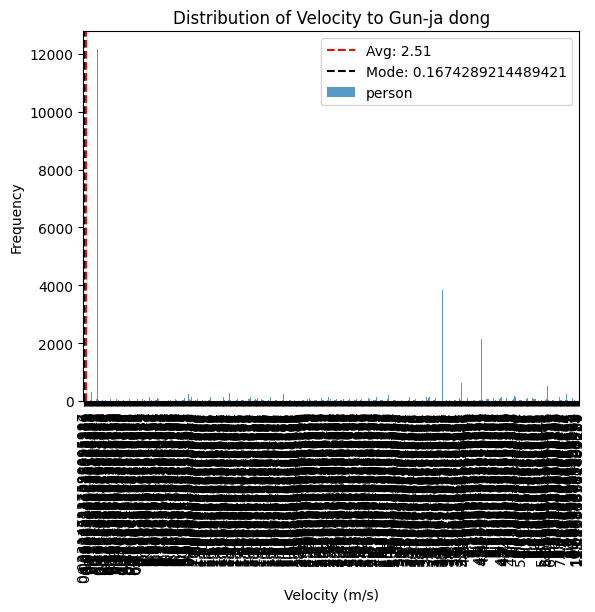

In [47]:
from scipy.stats import mode, skew, kurtosis
from scipy.stats import percentileofscore

# 'velocity(m/s)'을 기준으로 그룹화하고 'person' 값 합계
grouped_cal_df = grouped.groupby('velocity(m/s)').agg({'person': 'sum'}).reset_index()
print(grouped_cal_df.head())

# 가중 평균
weighted_avg = (grouped_cal_df['velocity(m/s)'] * grouped_cal_df['person']).sum() / grouped_cal_df['person'].sum()

# 최빈값
mode_value = grouped_cal_df.loc[grouped_cal_df['person'].idxmax(), 'velocity(m/s)']

# 가중치를 고려하여 왜도와 첨도 계산
data_expanded = []  # 데이터 확장
for index, row in grouped_cal_df.iterrows():
    data_expanded.extend([row['velocity(m/s)']] * int(row['person']))
skewness = skew(data_expanded)
kurt = kurtosis(data_expanded)

# 통계량 출력
print(f"Weighted Average: {weighted_avg:.2f}")
print(f"Mode: {mode_value}")
print(f"Skewness: {skewness:.2f}")
print(f"Kurtosis: {kurt:.2f}")

# Plot 그리기
plt.figure(figsize=(10,8))
grouped_cal_df.plot(x='velocity(m/s)', y='person', kind='bar', legend=None, alpha=0.75)
plt.axvline(x=weighted_avg, color='r', linestyle='--', label=f"Avg: {weighted_avg:.2f}")
plt.axvline(x=mode_value, color='k', linestyle='--', label=f"Mode: {mode_value}")
plt.xlabel('Velocity (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Velocity to Gun-ja dong')
plt.legend()
plt.show()

In [48]:
# # 두 열을 반올림하고 정수로 변환
# timebin_df['person'] = timebin_df['person'].replace('*', '0').astype(float)
# timebin_df['mean moving time'] = timebin_df['mean moving time'].round().astype(int)
# timebin_df['person'] = timebin_df['person'].round().astype(int)



# # 'mean moving time'을 기준으로 그룹화하고 'person' 값 합계
# timebin_cal_df = timebin_df.groupby('mean moving time').agg({'person': 'sum'}).reset_index()
# print(timebin_cal_df.head())

# import matplotlib.pyplot as plt
# from scipy.stats import skew, kurtosis

# # 가중치를 고려하여 왜도와 첨도 계산
# data_expanded = []  # 데이터 확장
# for index, row in timebin_cal_df.iterrows():
#     data_expanded.extend([row['mean moving time']] * row['person'])
# skewness = skew(data_expanded)
# kurt = kurtosis(data_expanded)

# # 가중 평균
# weighted_avg = (timebin_cal_df['mean moving time'] * timebin_cal_df['person']).sum() / timebin_cal_df['person'].sum()

# # 최빈값
# mode_value = timebin_cal_df.loc[timebin_cal_df['person'].idxmax(), 'mean moving time']

# # 통계량 출력
# print(f"Weighted Average: {weighted_avg:.2f}")
# print(f"Mode: {mode_value}")
# print(f"Skewness: {skewness:.2f}")
# print(f"Kurtosis: {kurt:.2f}")

# # Plot 그리기
# plt.figure(figsize=(10,8))
# timebin_cal_df.plot(x='mean moving time', y='person', kind='bar', legend=None, alpha=0.75)
# plt.axvline(x=weighted_avg, color='r', linestyle='--', label=f"Avg: {weighted_avg:.2f}")
# plt.axvline(x=mode_value, color='k', linestyle='--', label=f"Mode: {mode_value}")
# plt.axvline(x=90, color='b', linestyle='--')
# plt.xlabel('Mean Moving Time')
# plt.ylabel('Frequency')
# plt.title('Distribution of Mean Moving Time to Hya-Yeong')
# # X축 틱 설정
# max_val = 200
# min_val = 0
# plt.xticks(np.arange(-1, 201,10 ), rotation=70)
# plt.xlim([min_val, max_val])
# plt.legend()
# plt.show()

# # 데이터 정렬
# sorted_data = sorted(data_expanded)

# # 90 값의 위치 찾기
# index_90 = sorted_data.index(90)

# # 누적분포 백분율 계산
# cdf_90 = (index_90 + 1) / len(sorted_data) * 100

# print(f"90 value is at {cdf_90:.2f}% of the cumulative distribution.")



In [49]:
grouped.head()

,star_area,weighted_time,person,weighted_avg,ADM_CD,x_centroid,y_centroid,distance_from_gunja,velocity(m/s)
0,1101055,2773,38,4378,1101055.0,196710.993587,454961.123229,18609.568592,4.250701
1,1101056,462,7,3960,1101056.0,197116.279199,457039.297747,12297.760772,3.105495
2,1101061,1725,36,2875,1101061.0,199034.685820,452543.698587,7523.633260,2.616916
3,1101064,200,4,3000,1101064.0,200197.384691,453046.965380,8457.226158,2.819075
4,1101067,468,6,4680,1101067.0,201149.803528,452231.149979,2150.749649,0.459562


In [50]:
map

,BASE_DATE,ADM_CD,ADM_NM,geometry,x_centroid,y_centroid
2005,20220630,3304354,가경동,"POLYGON ((238950.246 348040.672, 238960.635 34...",238772.682280,346655.364351
3257,20220630,3808055,가곡동,"POLYGON ((362995.030 221745.449, 363023.674 22...",361602.995578,220898.464927
2080,20220630,3358033,가곡면,"POLYGON ((329921.049 397614.347, 329944.352 39...",327324.325034,391286.459680
1843,20220630,3207035,가곡면,"POLYGON ((393701.795 413370.265, 393711.539 41...",392658.976209,404669.599373
1700,20220630,3128011,가남읍,"POLYGON ((248869.160 418216.445, 248845.338 41...",251431.298370,412079.759792
...,...,...,...,...,...,...
1412,20220630,3110151,흥도동,"POLYGON ((186054.402 460221.433, 186067.559 46...",187652.936775,458958.968203
1287,20220630,3103067,흥선동,"POLYGON ((201310.924 472465.478, 201318.596 47...",201536.303372,470708.937761
1771,20220630,3202036,흥업면,"POLYGON ((278947.081 427585.367, 278988.790 42...",279451.879322,420808.362469
1702,20220630,3128033,흥천면,"POLYGON ((248033.233 431346.035, 248012.614 43...",247194.168200,427169.450846


In [51]:
grouped

,star_area,weighted_time,person,weighted_avg,ADM_CD,x_centroid,y_centroid,distance_from_gunja,velocity(m/s)
0,1101055,2773,38,4378,1101055.0,196710.993587,454961.123229,18609.568592,4.250701
1,1101056,462,7,3960,1101056.0,197116.279199,457039.297747,12297.760772,3.105495
2,1101061,1725,36,2875,1101061.0,199034.685820,452543.698587,7523.633260,2.616916
3,1101064,200,4,3000,1101064.0,200197.384691,453046.965380,8457.226158,2.819075
4,1101067,468,6,4680,1101067.0,201149.803528,452231.149979,2150.749649,0.459562
...,...,...,...,...,...,...,...,...,...
619,3137032,2654,26,6125,NaN,NaN,NaN,NaN,NaN
620,3138011,380,5,4560,NaN,NaN,NaN,NaN,NaN
621,3138035,2669,29,5522,NaN,NaN,NaN,NaN,NaN
622,3138040,4004,33,7280,NaN,NaN,NaN,NaN,NaN


/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.

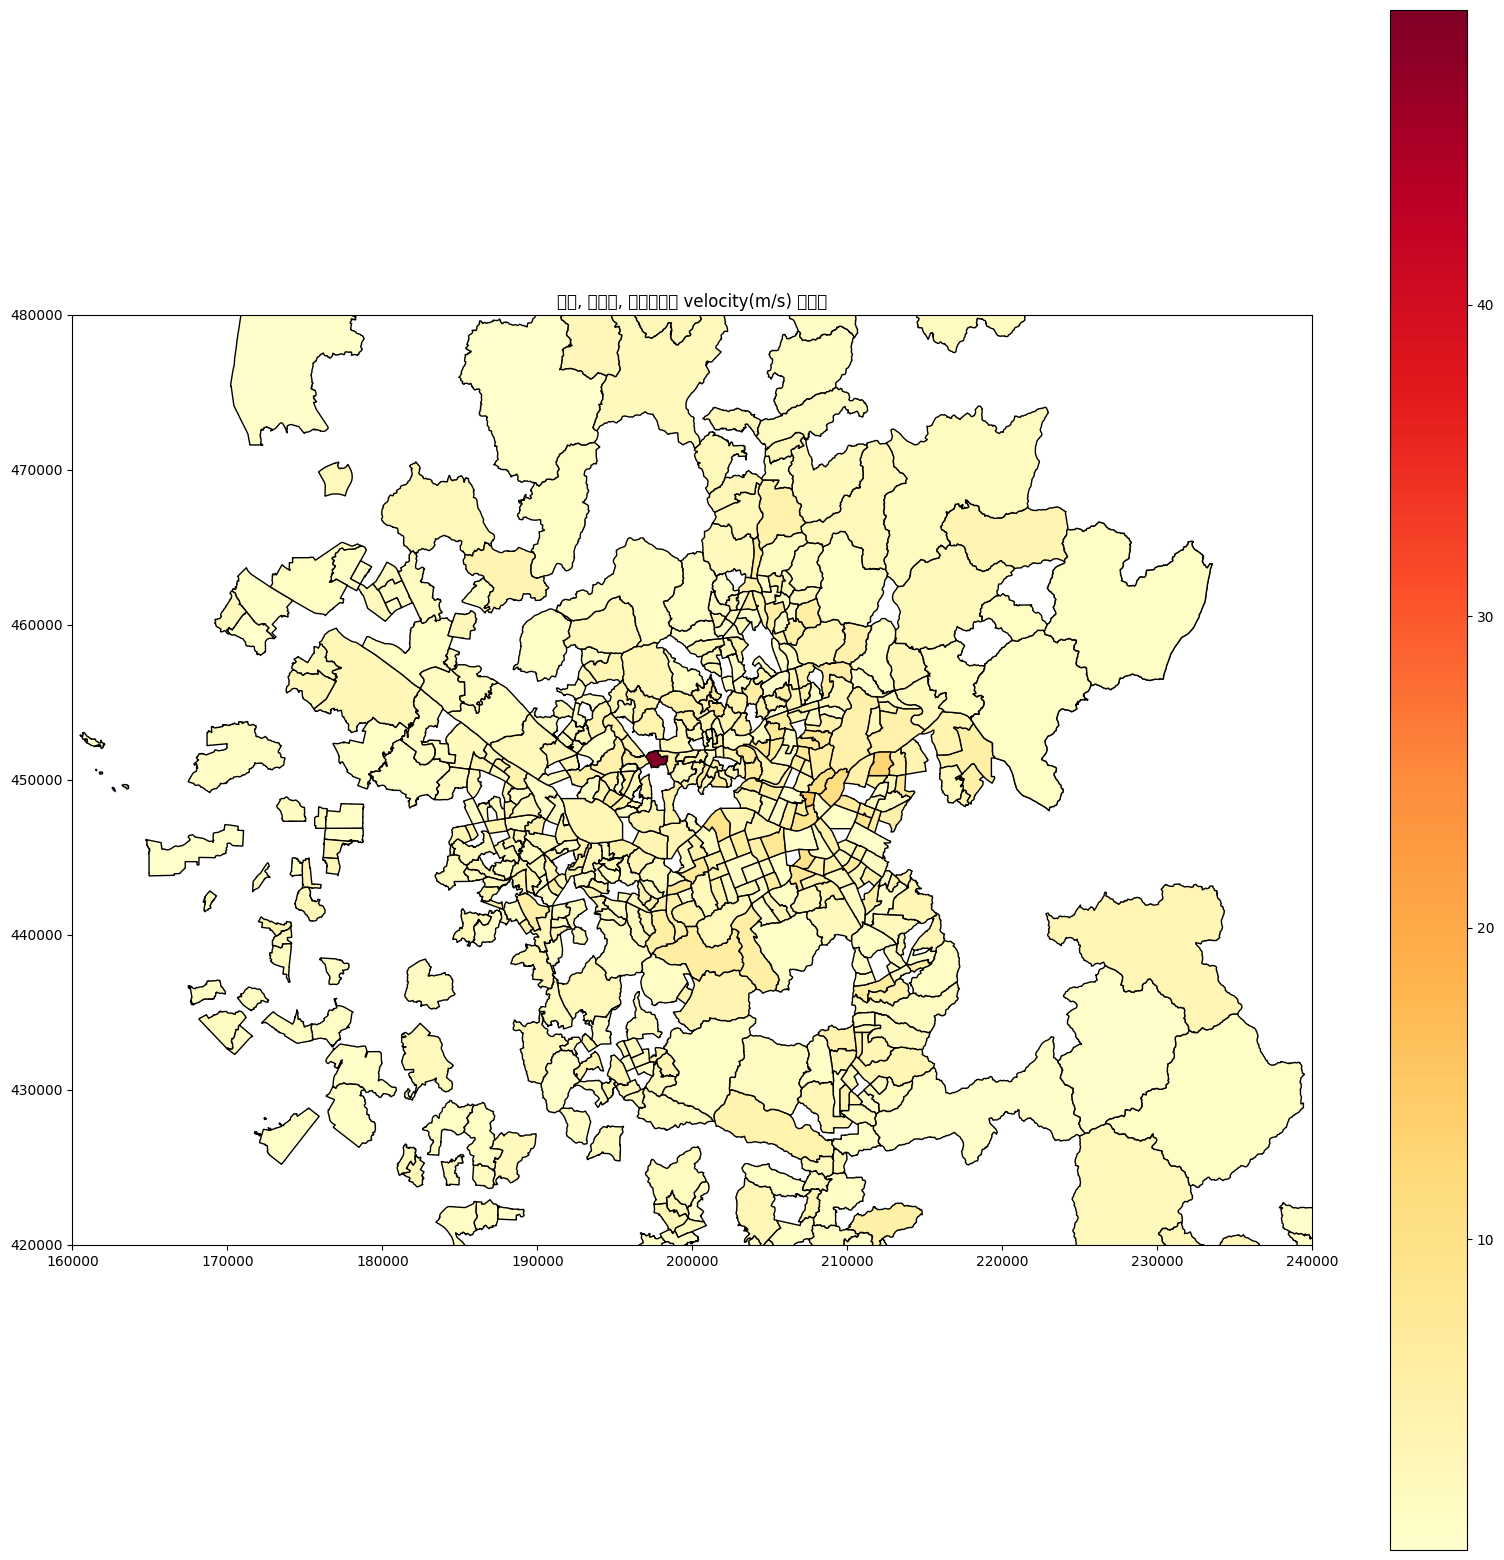

In [52]:
import geopandas as gpd
from google.colab import drive
import matplotlib.pyplot as plt

# NaN 값을 제거하고 데이터를 결합
grouped = grouped.dropna(subset=['velocity(m/s)'])
merged = map.merge(grouped, on='ADM_CD')
# 지도 필터링: 서울, 경기도, 인천
seoul_merged = merged[merged['ADM_CD'] < 12000000]
gyeonggi_merged = merged[(merged['ADM_CD'] >= 31000000) & (merged['ADM_CD'] < 32000000)]
incheon_merged = merged[(merged['ADM_CD'] >= 23000000) & (merged['ADM_CD'] < 24000000)]

# 그래프 그리기
fig, ax = plt.subplots(figsize=(20, 20))

seoul_merged.plot(column='velocity(m/s)', ax=ax, legend=True, cmap='YlOrRd', edgecolor='black')
gyeonggi_merged.plot(column='velocity(m/s)', ax=ax, legend=True, cmap='YlOrRd', edgecolor='black')
incheon_merged.plot(column='velocity(m/s)', ax=ax, legend=True, cmap='YlOrRd', edgecolor='blue')

# 지정된 xlim, ylim 값
xlim = [160000, 240000]
ylim = [420000, 480000]

plt.title("서울, 경기도, 인천광역시 velocity(m/s) 히트맵")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/geopandas/plotting.py:695: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.

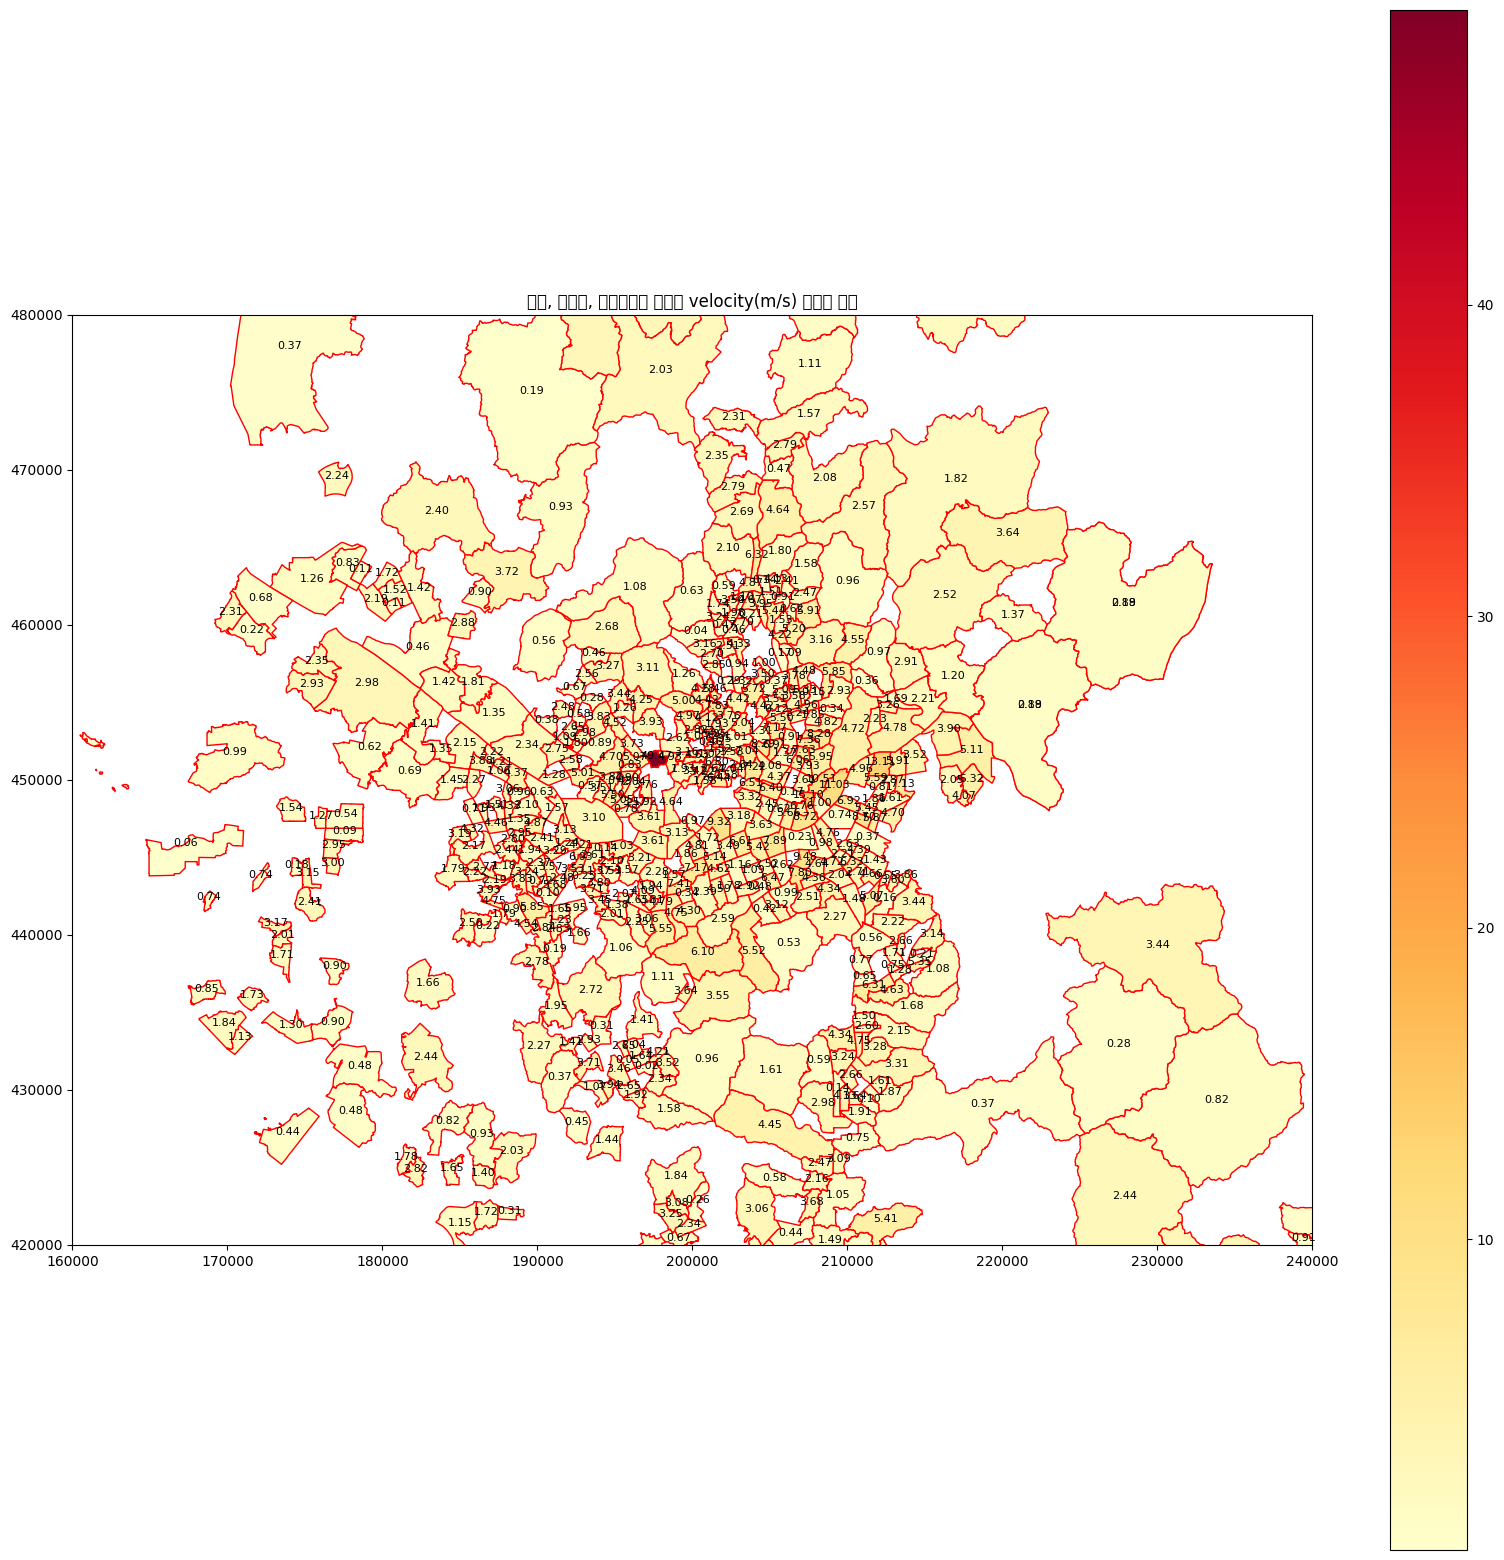

In [53]:
import geopandas as gpd
from google.colab import drive
import matplotlib.pyplot as plt



# NaN 값을 제거하고 데이터를 결합
grouped = grouped.dropna(subset=['velocity(m/s)'])
merged = map.merge(grouped, on='ADM_CD')

# 지도 필터링: 서울, 경기도, 인천
seoul_merged = merged[merged['ADM_CD'] < 12000000]
gyeonggi_merged = merged[(merged['ADM_CD'] >= 31000000) & (merged['ADM_CD'] < 32000000)]
incheon_merged = merged[(merged['ADM_CD'] >= 23000000) & (merged['ADM_CD'] < 24000000)]

# 그래프 그리기
fig, ax = plt.subplots(figsize=(20, 20))

seoul_merged.plot(column='velocity(m/s)', ax=ax, legend=True, cmap='YlOrRd', edgecolor='red')
gyeonggi_merged.plot(column='velocity(m/s)', ax=ax, legend=True, cmap='YlOrRd', edgecolor='black')
incheon_merged.plot(column='velocity(m/s)', ax=ax, legend=True, cmap='YlOrRd', edgecolor='blue')

# 지정된 xlim, ylim 값
xlim = [160000, 240000]
ylim = [420000, 480000]

# 각 행정동의 중심에서 velocity(m/s) 값을 표시
for df in [seoul_merged, gyeonggi_merged, incheon_merged]:
    centroids = df.geometry.centroid
    for x, y, label in zip(centroids.x, centroids.y, df['velocity(m/s)']):
        if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:  # xlim, ylim 범위 내에 있는지 확인
            ax.text(x, y, f"{label:.2f}", fontsize=8, ha='center')

plt.title("서울, 경기도, 인천광역시 지도에 velocity(m/s) 값으로 표시")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


데이터 형태 설명 현재 N개에서 -> 2개로 하는 페어로 형성이됨 그래서 [N1,N2]라면 N1은 어떤 행정에서 군자동으로 간 사람 N2는 어떤 행정동에서 화양동으로 간사람을 의미함

## 이전 코드

In [ ]:
combined_list # 결과 리스트

In [ ]:
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({ 'ADM_CD' : 'int' })
df1.info()
map = df1 # 서울시 한정 [df1['ADM_CD']<20000000]
map = map.sort_values(by='ADM_NM')
map_ori = map.copy(deep=True)
map['ADM_CD'] = map['ADM_CD'] // 10
map.head(20)

In [ ]:
print(map.crs)


In [ ]:
import pandas as pd

# dong_name 리스트에서 특정 값을 제외
dong_name = [name for name in dong_name if name not in [1105054]] #, 1105053]]

# combined_list를 열로 추가하기 위해 리스트를 분해
a_values = [item[0] for item in combined_list]
# b_values = [item[1] for item in combined_list]

# 새로운 데이터프레임 생성
df_new = pd.DataFrame({
    'dong': dong_name,
    'a_values': a_values,
    # 'b_values': b_values
})

# df_all에서 dong_name과 일치하는 ['name'] 열의 값을 새로운 데이터프레임에 추가
df_new = df_new.merge(df_all[['dong', 'name']], on='dong', how='left').drop_duplicates()
df_new.head()
# 각 행정동의 센트로이드 값을 계산하고, 해당 값의 x, y 좌표를 map 데이터프레임에 추가
map['x_centroid'] = map.geometry.centroid.x
map['y_centroid'] = map.geometry.centroid.y


df_new['dong'] = df_new['dong'].astype('int64') #자료 변환 map의 adm_cd가 int64임

# name과 ADM_CD를 기준으로 센트로이드 값을 df_new에 합치기
df_new = df_new.merge(map[['ADM_CD','x_centroid', 'y_centroid']], left_on='dong', right_on='ADM_CD', how='left')
print(df_new)
# 결측값 개수 확인
print(df_new.isnull().sum())

# 결측값이 포함된 행 제거
df_new = df_new.dropna()
df_new['ADM_CD'] = df_new['ADM_CD'].astype('int64')
# 결측값 제거 후의 데이터프레임 크기 확인
print(df_new.shape)


In [ ]:
df_new[df_new['name'] == '군자동']

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import mode, skew, kurtosis
from scipy.stats import percentileofscore

# 0 값을 제외
non_zero_a_values = df_new[df_new['a_values'] != 0]['a_values']

# 데이터의 최빈값, 평균, 중앙값 계산
mode_value = non_zero_a_values.mode()[0]
mean_value = non_zero_a_values.mean()
median_value = non_zero_a_values.median()

plt.figure(figsize=(10, 6))

# 히스토그램과 밀도 그래프 그리기
sns.histplot(non_zero_a_values, color='skyblue', kde=True)

# 최빈값, 평균, 중앙값에 수직선 그리기
plt.axvline(mode_value, color='r', linestyle='--')
plt.axvline(mean_value, color='g', linestyle='--')
plt.axvline(median_value, color='b', linestyle='--')
plt.axvline(60*90, color='k', linestyle='--')
# 최빈값, 평균, 중앙값에 텍스트 표시
plt.text(mode_value, 0.5, 'Mode', color='r', verticalalignment='bottom', rotation=90)
plt.text(mean_value, 0.5, 'Mean', color='g', verticalalignment='bottom', rotation=90)
plt.text(median_value, 0.5, 'Median', color='b', verticalalignment='bottom', rotation=90)

# 주요 통계치 계산
std_dev = non_zero_a_values.std()
skew_val = skew(non_zero_a_values)
kurt_val = kurtosis(non_zero_a_values)

# 60x90의 값에 대한 백분위 계산
percentile = percentileofscore(non_zero_a_values, 5400)

print(f"60x90의 값 (5400)은 약 {percentile:.2f} 백분위에 위치합니다.")
print(f"평균: {mean_value}")
print(f"중앙값: {median_value}")
print(f"최빈값: {mode_value}")
print(f"표준편차: {std_dev}")
print(f"왜도: {skew_val}")
print(f"첨도: {kurt_val}")

plt.title('Histogram and Density plot of a_values (Excluding Zeros)')
plt.xlabel('a_values')
plt.ylabel('Density')
plt.show()


In [ ]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # 지구의 반경 (킬로미터)

    dlat = math.radians(lat2 - lat1)
    dlon = math.radians(lon2 - lon1)

    a = (math.sin(dlat / 2) * math.sin(dlat / 2) +
         math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) *
         math.sin(dlon / 2) * math.sin(dlon / 2))

    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# 군자동의 centroid 값
print(map[map['ADM_CD']==1105054])
gunja_row = map[map['ADM_CD']==1105054].iloc[0]
gunja_lat = gunja_row['y_centroid']
gunja_lon = gunja_row['x_centroid']

# 각 행정동의 centroid와 군자동과의 거리 계산
df_new['distance_from_gunja'] = df_new.apply(lambda row: haversine_distance(gunja_lat, gunja_lon, row['y_centroid'], row['x_centroid']), axis=1)


# def euclidean_distance(x1, y1, x2, y2):
#     return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)

# # 군자동의 centroid 값
# gunja_row = map[map['ADM_CD']==1105054].iloc[0]
# gunja_lat = gunja_row['y_centroid']
# gunja_lon = gunja_row['x_centroid']

# # 각 행정동의 centroid와 군자동과의 거리 계산
# df_new['distance_from_gunja'] = df_new.apply(lambda row: euclidean_distance(gunja_lat, gunja_lon, row['y_centroid'], row['x_centroid']), axis=1)


In [ ]:
df_new.head()
df_new['a_values'] = df_new['a_values'] / 11
df_new['a_values'] = df_new['a_values'] * 60
df_new['velocity(m/s)'] = df_new['distance_from_gunja'] / df_new['a_values']
df_new['velocity(m/s)'] = df_new['velocity(m/s)']
df_new = df_new[np.isfinite(df_new['velocity(m/s)'])]

df_new = df_new.dropna(subset=['velocity(m/s)'])  # 'velocity(m/s)' 열에서 NaN 값을 제거
print(df_new['velocity(m/s)'][~np.isfinite(df_new['velocity(m/s)'])])

df_new['velocity(m/s)'] = df_new['velocity(m/s)'].astype(int)



df_new.head()

In [ ]:
import matplotlib.pyplot as plt

# 값의 빈도 계산
value_counts = df_new['velocity(m/s)'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
plt.scatter(value_counts.index, value_counts.values, color='blue')
plt.title('Distribution of Velocity (m/s)')
plt.xlabel('Velocity (m/s)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



In [ ]:
df_new.head(20)

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
xlim = [160000,240000]
ylim = [420000,480000]
# df와 map를 ADM_CD를 기준으로 결합
# df_temp = df_new[df_new['ADM_CD', 'velocity(m/s)']]
import geopandas as gpd
import matplotlib.pyplot as plt

# 데이터프레임 결합
merged = map.set_index('ADM_CD').join(df_new.set_index('ADM_CD'), lsuffix='_map', rsuffix='_df_new')

# xlim, ylim 범위 내에 있는 행정동만 선택
filtered_merged = merged[
    (merged['x_centroid_map'] >= xlim[0]) & (merged['x_centroid_map'] <= xlim[1]) &
    (merged['y_centroid_map'] >= ylim[0]) & (merged['y_centroid_map'] <= ylim[1])
].copy()

# velocity(m/s) 값 100 이상을 100으로 제한
filtered_merged['velocity(m/s)_capped'] = filtered_merged['velocity(m/s)'].apply(lambda x: 50 if x > 50 else x)

# 지도 데이터 가져오기
fig, ax = plt.subplots(figsize=(20, 20))

# 히트맵 그리기
filtered_merged.plot(column='velocity(m/s)_capped', cmap='YlOrRd', linewidth=2, ax=ax, edgecolor='black', legend=True)

# 각 행정동 중앙에 velocity(m/s) 값 표시
for x, y, label in zip(filtered_merged['x_centroid_map'], filtered_merged['y_centroid_map'], filtered_merged['velocity(m/s)']):
    if not pd.isna(label):
        ax.text(x, y, str(int(label)), fontsize=10, ha='center', va='center')

plt.title("서울 지도에 표현한 생활인구이동량")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()



In [ ]:
import numpy as np
from scipy.stats import mode

# 통계량 계산
mean_val = df_new['distance_from_gunja'].mean()
median_val = df_new['distance_from_gunja'].median()

# 최빈값 계산: `mode()` 함수의 반환값 처리
mode_result = mode(df_new['distance_from_gunja'])
mode_val = mode_result.mode[0] if mode_result.count > 1 else np.nan

std_dev = df_new['distance_from_gunja'].std()

plt.figure(figsize=(10, 6))

# 히스토그램과 KDE plot 함께 그리기
sns.histplot(df_new['distance_from_gunja'], kde=True, color='skyblue')

# 통계량에 대한 수직선 그리기
plt.axvline(mean_val, color='g', linestyle='--')
plt.axvline(median_val, color='b', linestyle='--')
if not np.isnan(mode_val):
    plt.axvline(mode_val, color='r', linestyle='--')

# 통계량에 대한 텍스트 표시
plt.text(mean_val, 0.5, 'Mean', color='g', verticalalignment='bottom', rotation=90)
plt.text(median_val, 0.5, 'Median', color='b', verticalalignment='bottom', rotation=90)
if not np.isnan(mode_val):
    plt.text(mode_val, 0.5, 'Mode', color='r', verticalalignment='bottom', rotation=90)

plt.title('Histogram and Density plot of Distance from Gunja-dong')
plt.xlabel('Distance (km)')
plt.ylabel('Density/Frequency')
plt.show()

print(f"평균: {mean_val:.2f} km")
print(f"중앙값: {median_val:.2f} km")
print(f"최빈값: {mode_val:.2f} km" if not np.isnan(mode_val) else "최빈값: 없음")
print(f"표준편차: {std_dev:.2f} km")



In [ ]:
stop

##시각화

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3518 entries, 0 to 3517
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   BASE_DATE  3518 non-null   object  
 1   ADM_CD     3518 non-null   int64   
 2   ADM_NM     3518 non-null   object  
 3   geometry   3518 non-null   geometry
dtypes: geometry(1), int64(1), object(2)
memory usage: 110.1+ KB


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50872 (\N{HANGUL SYLLABLE UL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/

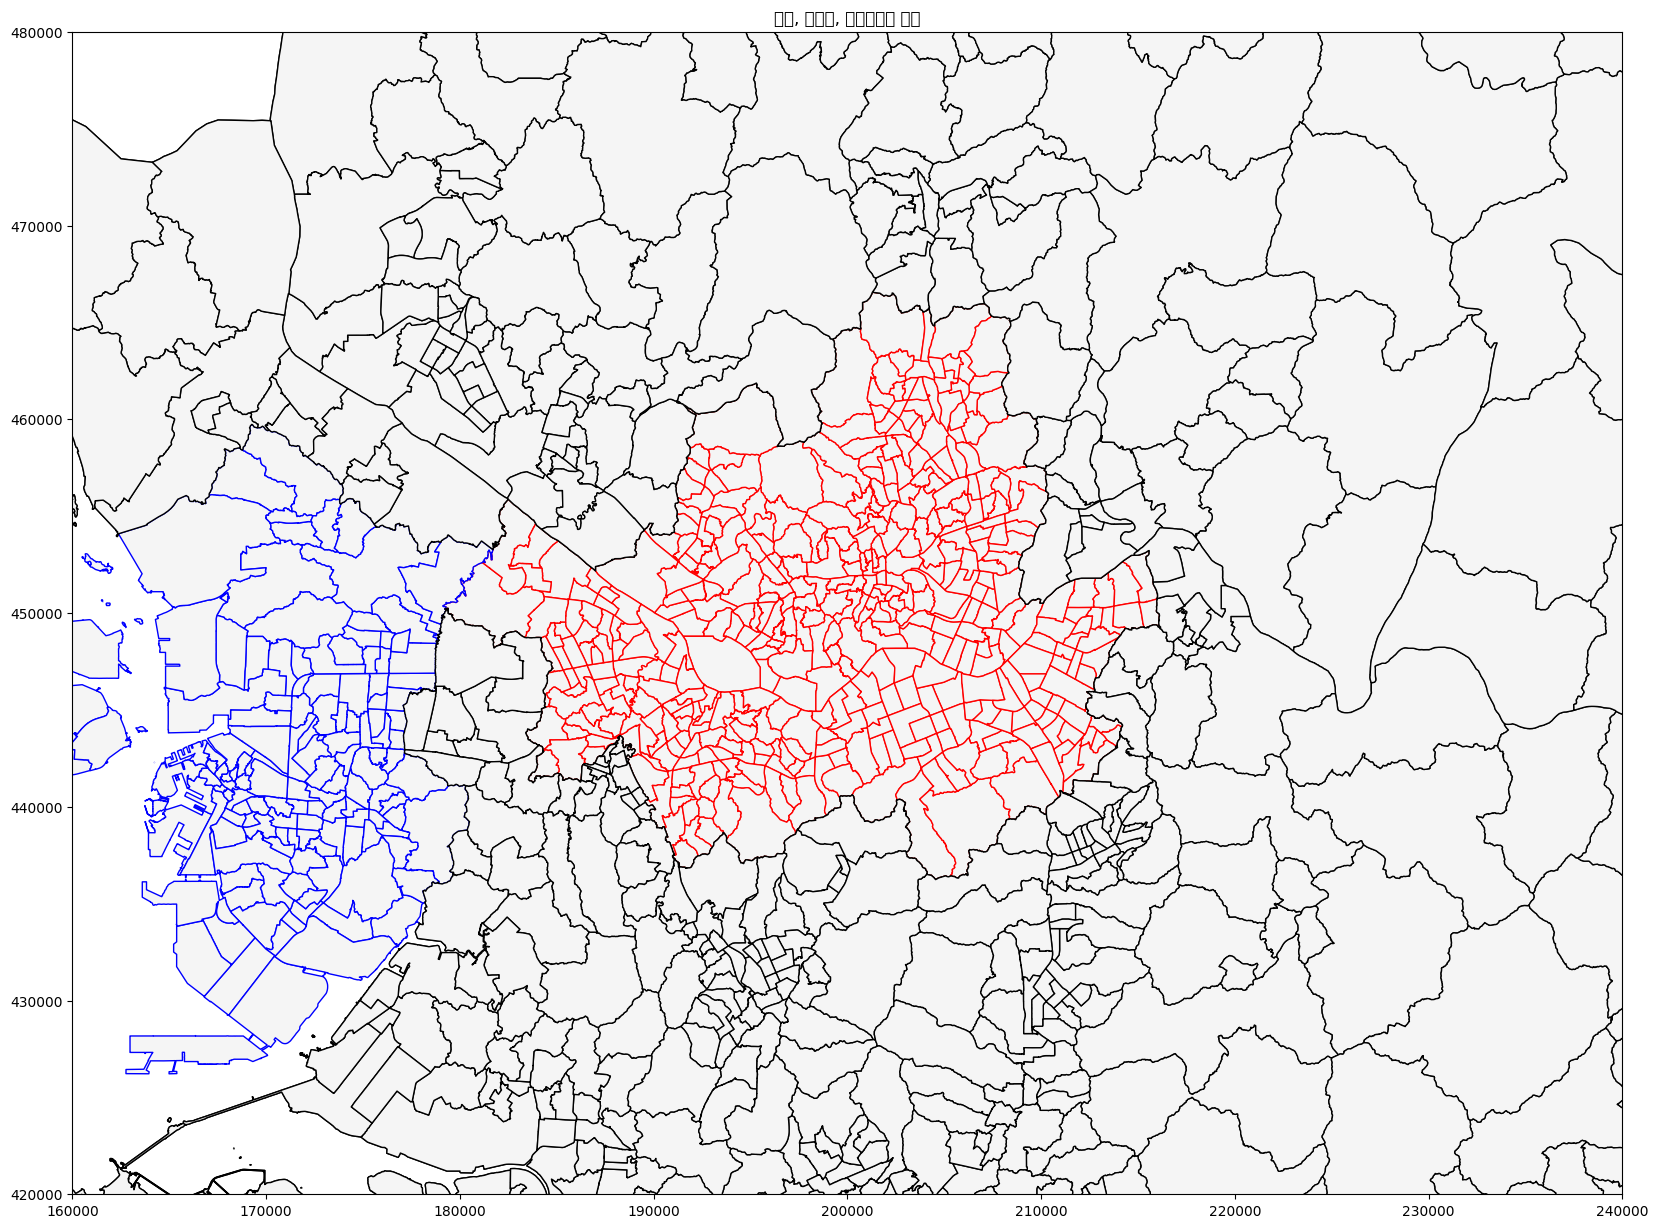

In [54]:
import geopandas as gpd
from google.colab import drive
drive.mount('/content/gdrive')
import matplotlib.pyplot as plt
# prepare and read data
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({ 'ADM_CD' : 'int' })
df1.info()
map = df1 # 서울시 한정 [df1['ADM_CD']<20000000]
# 데이터 필터링: 서울, 경기도, 인천광역시 한정

# 데이터 필터링: 서울시 한정
seoul_map = map[map['ADM_CD'] < 12000000]
gyeonggi_map = map[(map['ADM_CD'] >= 31000000) & (map['ADM_CD'] < 32000000)]
incheon_map = map[(map['ADM_CD'] >= 23000000) & (map['ADM_CD'] < 24000000)]

# 각 행정동의 중심 계산
centroids = map.geometry.centroid

# combined_list에서 a값만 가져오기
a_values = [item[0] for item in combined_list]

# 그래프 그리기
fig, ax = plt.subplots(figsize=(20, 20))
seoul_map.plot(ax=ax, color='whitesmoke', edgecolor='red')
gyeonggi_map.plot(ax=ax, color='whitesmoke', edgecolor='black')
incheon_map.plot(ax=ax, color='whitesmoke', edgecolor='blue')

# 지정된 xlim, ylim 값
xlim = [160000,240000]
ylim = [420000,480000]

# 각 행정동 중앙에 생활인구이동량 표시 (a 값만, xlim과 ylim 영역에 포함된 중심만)
for idx, (x, y, label) in enumerate(zip(centroids.x, centroids.y, a_values)):
    if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:
        ax.text(x, y, str(label), fontsize=8, ha='center')

# 경기도 행정동의 중심 계산
gyeonggi_centroids = gyeonggi_map.geometry.centroid
# 경기도 행정동에 해당하는 생활인구 이동량 a_values 추출
gyeonggi_a_values = a_values[len(seoul_map):len(seoul_map)+len(gyeonggi_map)]
gyeonggi_map.plot(ax=ax, color='whitesmoke', edgecolor='black')
# 경기도 행정동 중앙에 생활인구이동량 표시 (a 값만)
for x, y, label in zip(gyeonggi_centroids.x, gyeonggi_centroids.y, gyeonggi_a_values):
    if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:  # xlim, ylim 범위 내에 있는지 확인
        ax.text(x, y, str(label), fontsize=8, ha='center')

plt.title("서울, 경기도, 인천광역시 지도")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()







In [ ]:
map.head()
df_all
# len(df_all)

In [ ]:
import geopandas as gpd
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')

# prepare and read data
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({'ADM_CD': 'int'})
df1.info()

map = df1

# 데이터 필터링: 서울, 경기도, 인천광역시 한정
seoul_map = map[map['ADM_CD'] < 12000000]
gyeonggi_map = map[(map['ADM_CD'] >= 31000000) & (map['ADM_CD'] < 32000000)]
incheon_map = map[(map['ADM_CD'] >= 23000000) & (map['ADM_CD'] < 24000000)]

# 각 행정동의 중심 계산
centroids = map.geometry.centroid

# combined_list에서 a값만 가져오기
a_values = [item[0] for item in combined_list]
print(len(a_values))
# 지정된 xlim, ylim 값
xlim = [160000,240000]
ylim = [420000,480000]

# 각 행정동 중앙에 생활인구이동량 표시 (a 값만, xlim과 ylim 영역에 포함된 중심만)
data_list = []

for idx, (x, y, label) in enumerate(zip(centroids.x, centroids.y, a_values)):
    if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:
        data_list.append({"x": x, "y": y, "population_movement": label})

# 경기도 행정동의 중심 계산 및 데이터프레임에 추가
gyeonggi_centroids = gyeonggi_map.geometry.centroid
gyeonggi_a_values = a_values[len(seoul_map):len(seoul_map)+len(gyeonggi_map)]

for x, y, label in zip(gyeonggi_centroids.x, gyeonggi_centroids.y, gyeonggi_a_values):
    if xlim[0] <= x <= xlim[1] and ylim[0] <= y <= ylim[1]:
        data_list.append({"x": x, "y": y, "population_movement": label})

# DataFrame으로 변환
df_centroid_pop = pd.DataFrame(data_list)


print(len(df_centroid_pop))
print(df_centroid_pop)


In [ ]:
map.head()

In [ ]:
df_centroid_pop

In [ ]:
import geopandas as gpd
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')

# prepare and read data
F1 = '/content/gdrive/My Drive/seoulmovingdata/Z_SOP_BND_ADM_DONG_PG.shp'
D1 = gpd.read_file(F1, encoding='cp949')
df1 = D1.astype({'ADM_CD': 'int'})
map = df1

# Add population_movement to our main geopandas dataframes
map = map.merge(df_centroid_pop[['ADM_CD', 'population_movement']], on='ADM_CD', how='left')

# Filter regions
seoul_map = map[map['ADM_CD'] < 12000000]
gyeonggi_map = map[(map['ADM_CD'] >= 31000000) & (map['ADM_CD'] < 32000000)]
incheon_map = map[(map['ADM_CD'] >= 23000000) & (map['ADM_CD'] < 24000000)]

fig, ax = plt.subplots(figsize=(20, 20))

# Draw the colored maps based on population_movement
seoul_map.plot(ax=ax, column='population_movement', cmap='viridis', legend=True)
gyeonggi_map.plot(ax=ax, column='population_movement', cmap='viridis')
incheon_map.plot(ax=ax, column='population_movement', cmap='viridis')

# 지정된 xlim, ylim 값
xlim = [160000,240000]
ylim = [420000,480000]

plt.title("서울, 경기도, 인천광역시 생활인구 이동량 히트맵")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()



In [ ]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

# 생략: 데이터 로딩 및 전처리 코드 ...

# xlim과 ylim 범위 설정
xlim = [160000,240000]
ylim = [420000,480000]

# xlim과 ylim 범위에 있는 행정동만 필터링
map_in_xlim = map[map.bounds.minx >= xlim[0]]
map_in_xlim = map_in_xlim[map_in_xlim.bounds.maxx <= xlim[1]]
map_in_ylim = map_in_xlim[map_in_xlim.bounds.miny >= ylim[0]]
filtered_map = map_in_ylim[map_in_ylim.bounds.maxy <= ylim[1]]

# 해당 행정동의 생활인구 이동량 값만 가져오기
filtered_a_values = [a_values[i] for i in filtered_map.index]

# 히트맵 그리기: 색상은 생활인구 이동량에 따라 지정됨
fig, ax = plt.subplots(figsize=(20, 20))
filtered_map.plot(column=np.array(filtered_a_values), cmap='OrRd', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True)

plt.title("서울, 경기도, 인천광역시 지도 내의 생활인구 이동량 히트맵")
plt.xlim(xlim)
plt.ylim(ylim)
plt.show()


In [ ]:
# 경기도 행정동의 중심 계산
gyeonggi_centroids = gyeonggi_map.geometry.centroid

# 경기도 행정동에 해당하는 생활인구 이동량 a_values 추출
gyeonggi_a_values = a_values[len(seoul_map):len(seoul_map)+len(gyeonggi_map)]

# 그래프 그리기
fig, ax = plt.subplots(figsize=(12, 12))
gyeonggi_map.plot(ax=ax, color='whitesmoke', edgecolor='black')

# 경기도 행정동 중앙에 생활인구이동량 표시 (a 값만)
for x, y, label in zip(gyeonggi_centroids.x, gyeonggi_centroids.y, gyeonggi_a_values):
    ax.text(x, y, str(label), fontsize=8, ha='center')

plt.title("경기도 지도 - 생활인구 이동량 표시")
plt.xlim([160000,240000])
plt.ylim([420000,480000])
plt.show()


In [ ]:
print(dong_name_real)
print(dong_name_two)
print(len(combined_list))
print(len(combined_list[1]))

In [ ]:
# scaler = MinMaxScaler()

# # 스케일링 적용
# scaled_population_movement = scaler.fit_transform(population_moving_amount)

# # 스케일링된 데이터 출력
# print(scaled_population_movement)

In [ ]:
import numpy as np
import networkx as nx
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt

# 서울 자치구 리스트
districts = dong_name_real
node_labels = {i: dong_name[i] for i in range(len(dong_name))}
# 인구 이동량 데이터
population_movement = np.array(combined_list)

# 방향 그래프 생성
G = nx.DiGraph()
for i, district in enumerate(districts):
    G.add_node(i, label=district)

for i in range(len(districts)):
    for j in range(len(dong_name_two)):
        if i != j:  # i와 j가 다른 경우에만 간선을 추가
          weight = population_movement[i, j]
          G.add_edge(i, j, weight=weight)



In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 서울 자치구 리스트
districts = dong_name
node_labels = {i: dong_name[i] for i in range(len(dong_name))}
# 인구 이동량 데이터
population_movement = np.array(combined_list)

# 방향성이 없는 그래프 생성
G = nx.Graph()
for i, district in enumerate(districts):
    G.add_node(i, label=district)

for i in range(len(districts)):
    for j in range(len(dong_name_two)):
        if i != j:  # i와 j가 다른 경우에만 간선을 추가
            weight = population_movement[i, j]
            G.add_edge(i, j, weight=weight)

# 그래프 시각화
pos = nx.spring_layout(G)  # 노드 위치 결정을 위한 레이아웃
edge_weights = nx.get_edge_attributes(G, 'weight')  # 간선의 가중치 가져오기

# 노드와 간선 그리기
nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='skyblue', node_size=2000, font_size=12, font_weight='bold', width=list(edge_weights.values()), edge_color='gray')

# 간선의 가중치를 라벨로 표시
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

plt.title("서울 자치구 이동량 그래프")
plt.show()


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 서울 자치구 리스트
districts = dong_name
node_labels = {i: dong_name[i] for i in range(len(dong_name))}
# 인구 이동량 데이터
population_movement = np.array(combined_list)

# 방향성이 없는 그래프 생성
G = nx.Graph()
for i, district in enumerate(districts):
    G.add_node(i, label=district)

for i in range(len(districts)):
    for j in range(1):
        if i != j:  # i와 j가 다른 경우에만 간선을 추가
            weight = population_movement[i, j] ;
            G.add_edge(i, j, weight=weight)
# 그래프 시각화
pos = nx.spring_layout(G)  # 노드 위치 결정을 위한 레이아웃
edge_weights = nx.get_edge_attributes(G, 'weight')  # 간선의 가중치 가져오기

fig, ax = plt.subplots(figsize=(20, 15))  # 그래프 크기를 조절

# 노드와 간선 그리기
nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='skyblue', node_size=1000, font_size=10, font_weight='bold',  edge_color='gray', ax=ax)

# 간선의 가중치를 라벨로 표시
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, ax=ax)

plt.title("서울 자치구 이동량 그래프")
plt.show()


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 서울 자치구 리스트
districts = dong_name
node_labels = {i: dong_name[i] for i in range(len(dong_name))}

# 인구 이동량 데이터
population_movement = np.array(combined_list)

# 방향성이 없는 그래프 생성
G = nx.Graph()

for i, district in enumerate(districts):
    G.add_node(i, label=district)

j = 0  # 중심 노드
nodes_to_remove = []  # 가중치가 0인 노드를 저장하는 리스트
for i in range(len(districts)):
    if i != j:
        weight = population_movement[i, j]
        if weight != 0:  # 가중치가 0이 아닌 노드만 간선 추가
            G.add_edge(i, j, weight=weight)
        else:
            nodes_to_remove.append(i)

# 가중치가 0인 노드를 제거
G.remove_nodes_from(nodes_to_remove)

# 원형 레이아웃 계산
pos = {}
center = np.array([0.5, 0.5])
radius = 0.4  # 원의 반지름
for node in G.nodes():
    if node == j:
        pos[node] = center
    else:
        theta = float(node) / (len(G.nodes()) - 1) * 2 * np.pi
        pos[node] = center + np.array([radius * np.cos(theta), radius * np.sin(theta)])

edge_weights = {(i, j): G[i][j]['weight'] for i, j in G.edges()}

fig, ax = plt.subplots(figsize=(20, 15))  # 그래프 크기를 조절

# 노드와 간선 그리기
nx.draw(G, pos, with_labels=True, labels=node_labels, node_color='skyblue', node_size=1000, font_size=10, font_weight='bold', edge_color='gray', ax=ax)

# 간선의 가중치를 라벨로 표시
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights, font_size=8, ax=ax)

plt.title("서울 자치구 이동량 그래프")
plt.show()



In [ ]:
file_seuol_1 = '/content/gdrive/My Drive/seoulmovingdata/서울관련데이터/서울시 상권분석서비스(자치구별 상권변화지표) (1).csv'
graphic1 = pd.read_csv(file_seuol_1, encoding='cp949', index_col = None)
graphic1.head()

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 행정동 경계 데이터 로드

# 예시 데이터 생성 (실제 데이터로 교체 필요)
data = {
    '행정동이름': [districts[node] for node in total_degrees],
    '값': [total_degrees[node] for node in total_degrees]
}

df = pd.DataFrame(data)


# 행정동 이름을 기준으로 데이터 병합
merged = map.set_index('ADM_NM').join(df.set_index('행정동이름'))
# Q1, Q3 계산
Q1 = merged['값'].quantile(0.25)
Q3 = merged['값'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
merged_filtered = merged[(merged['값'] >= lower_bound) & (merged['값'] <= upper_bound)]
merged_filtered2 = merged[merged['값'] >= upper_bound]
print(merged_filtered2.head())
# scaler = MinMaxScaler()
# merged['scaled_data'] = scaler.fit_transform( merged[['값']] )
print(merged.head())
# merged.boxplot(column = 'scaled_data')
# 히트맵 그리기
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
merged_filtered.plot(column = '값', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,legend_kwds = {'shrink': 0.5})
merged_filtered2.plot(column = '값', cmap='Spectral', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True,legend_kwds = {'shrink': 0.5})
# map2[map2['TRDAR_SE_1'] == '골목상권'].convex_hull.plot(color='yellow', edgecolor='k', ax=ax)
# map2[map2['TRDAR_SE_1'] == '발달상권'].convex_hull.plot(color='green', edgecolor='k', ax=ax)
plt.title('서울 행정동 히트맵 예시')
plt.show()


#dummy

In [ ]:
# # 스펙트럼 클러스터링
# adj_matrix = nx.adjacency_matrix(G).todense()
# n_clusters = 3  # 클러스터 개수 설정
# clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', random_state=0).fit(adj_matrix)
# node_colors = clustering.labels_
# # 클러스터링 결과 출력
# print("Cluster Labels:", clustering.labels_)


# # 각 노드의 나가는 간선과 들어오는 간선의 가중치 합을 계산
# total_degrees = {node: G.out_degree(node, weight='weight') + G.in_degree(node, weight='weight') for node in G.nodes()}
# # 연결 중심성 값을 기준으로 노드를 정렬하고 상위 10개를 선택
# top_10_central_nodes = sorted(total_degrees, key=total_degrees.get, reverse=True)[:10]
# print("연결 중심성 상위 10위 노드:")
# for rank, node in enumerate(top_10_central_nodes, 1):
#     print(f"{rank}. {districts[node]}, 연결 중심성 값: {total_degrees[node]}")

# # 각 노드에 연결된 간선의 가중치를 기록하는 행렬 생성
# matrix_size = len(districts)
# connection_matrix = np.zeros((matrix_size, matrix_size))
# for i in range(matrix_size):
#     for j in range(len(dong_name_two)):
#         connection_matrix[i, j] = G.get_edge_data(i, j, default={'weight': 0})['weight']
# # Pearson 상관계수 계산
# correlation_matrix = np.corrcoef(connection_matrix)
# # 상관계수가 0.8 이상인 노드 쌍만 선택
# high_correlation_edges = []
# for i in range(matrix_size):
#     for j in range(len(dong_name_two)):
#         if i != j and correlation_matrix[i, j] >= 0.8:
#             high_correlation_edges.append((i, j))
# print("피어슨 상관계수 0.8이상인 노드쌍",high_correlation_edges[:10])

# # 매개 중심성 계산
# betweenness = nx.betweenness_centrality(G, weight='weight', normalized=True)
# # 상위 10개 노드 출력 및 저장
# sorted_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:4]
# top_10_nodes = [item[0] for item in sorted_betweenness]
# print("Top 10 nodes by 매개중심성:")
# for node, value in sorted_betweenness:
#     print(f"{node_labels[node]}: {value:.4f}")

# # 아이겐벡터 중심성 계산
# eigenvector_centrality = nx.eigenvector_centrality_numpy(G, weight='weight')

# # 상위 10개의 아이겐벡터 중심성 노드 출력
# top_10_eigenvector = sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
# print("Top 10 nodes by 아이겐벡터 중심성 노드:")
# for node, centrality in top_10_eigenvector:
#     print(f"Node {node_labels[node]}: {centrality:.4f}")